# Revisiting the Reservations - EDA and Data Wrangling

---

**Revenue Forecasting**

> **Proper revenue forecasting is a critical aspect of the revenue management cycle,** with the goal to maximize the hotel's revenues. Using the source dataset from two Portuguese hotels (one in an urban location and another a resort), I will utilize machine learning models to forecast the hotels' average daily rate ("ADR") based on common reservation details that would be known prior to arrival. 
>
> Before I train any models, I need to get an idea of my data, including its data types; distributions; presence/absence of outliers; and to brainstorm ideas for feature engineering.
>
> In this notebook, I explore the original dataset and identify specific features to remove from the data. I will determine whether to keep the feature in my modeling based on my domain knowledge of whether this data is commonly known prior to arrival.
>
> Once the data is prepared, I will perform further modeling and feature engineering in additional notebooks.

---

# Import Packages

In [ ]:
# import numpy as np
import pandas as pd

## Visualizations
# import matplotlib.pyplot as plt
import sweetviz as sv

## Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_rows', 50)
# %matplotlib inline

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sweetviz\graph.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [2]:
## Load datasets and add column to indicate hotel type/location

df_h1 = pd.read_csv('../../data/source/H1.csv')
df_h1['HotelNumber'] = 'H1'
df_h1['HotelNumber'] = df_h1['HotelNumber'].astype('string')
df_h1['ReservationStatusDate'] = pd.to_datetime(df_h1['ReservationStatusDate'], format='%Y-%m-%d')

df_h2 = pd.read_csv('../../data/source/H2.csv')
df_h2['HotelNumber'] = 'H2'
df_h2['HotelNumber'] = df_h2['HotelNumber'].astype('string')
df_h2['ReservationStatusDate'] = pd.to_datetime(df_h2['ReservationStatusDate'], format='%Y-%m-%d')

# Exploratory Data Analysis: Sweetviz Report

## Hotel 1

                                             |          | [  0%]   00:00 -> (? left)


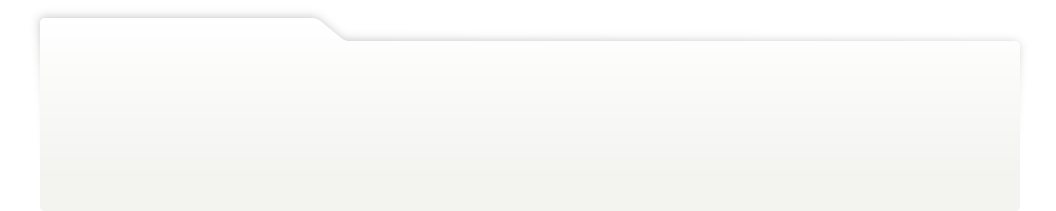
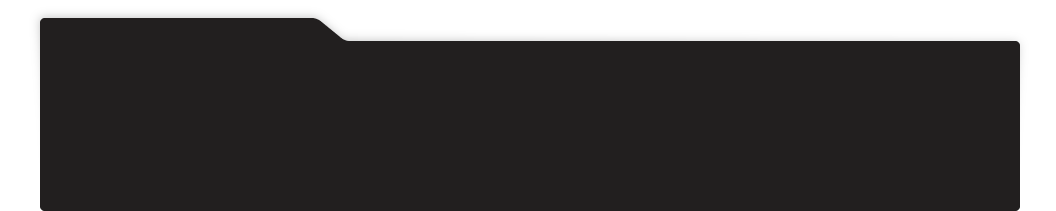
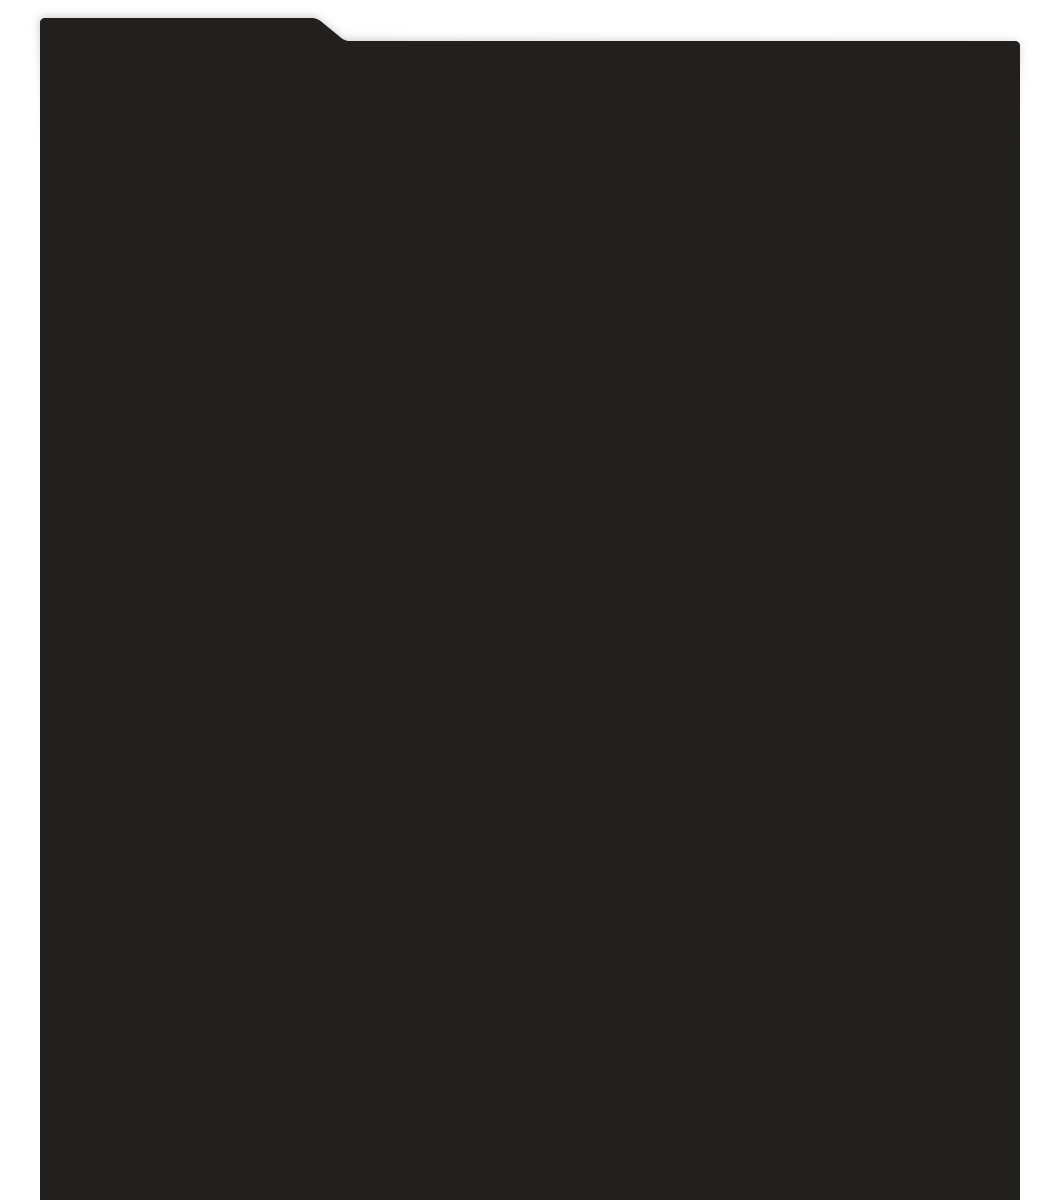
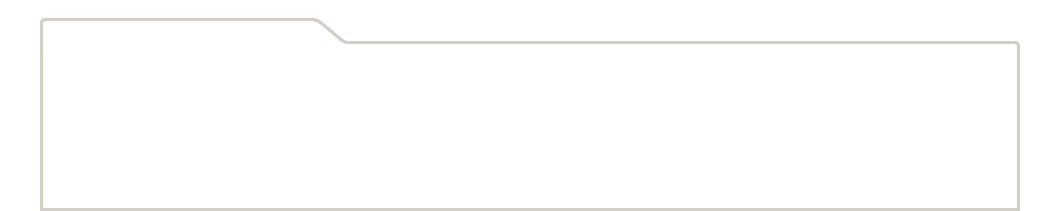
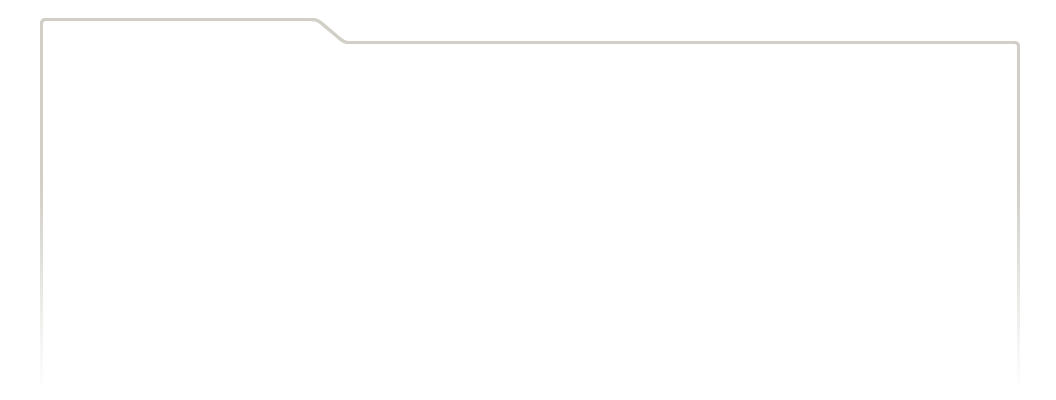
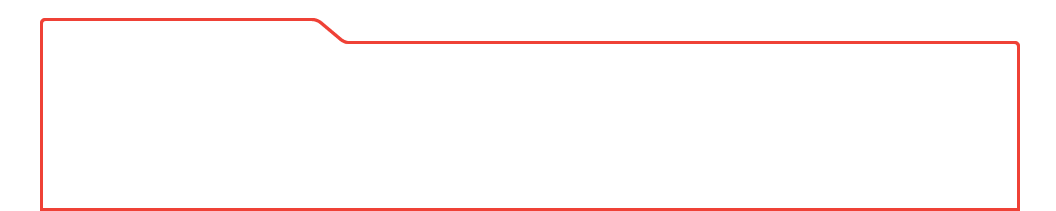
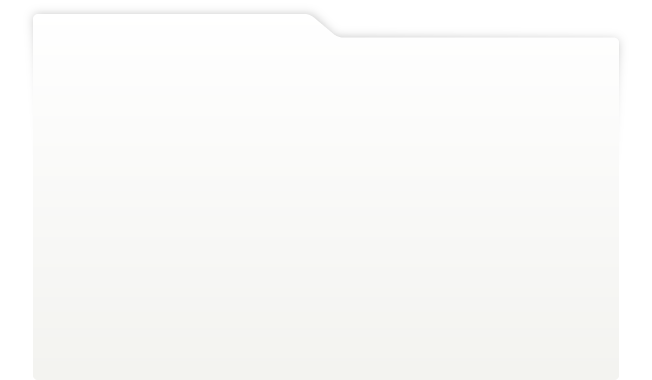
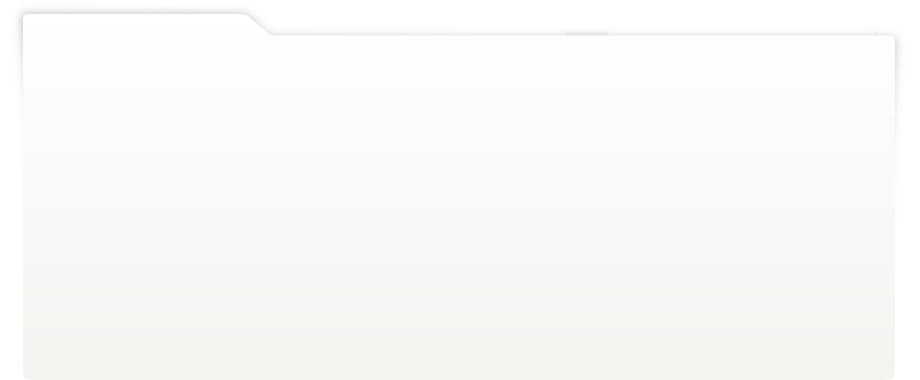
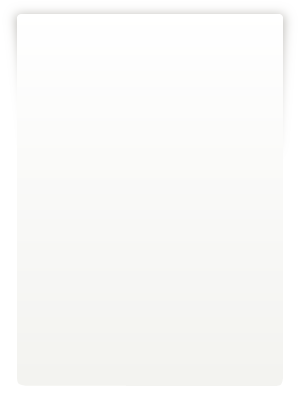
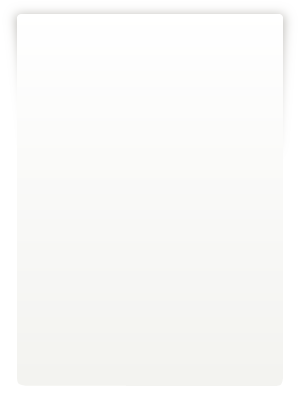
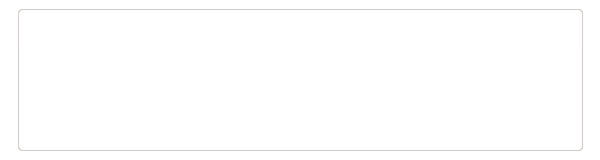
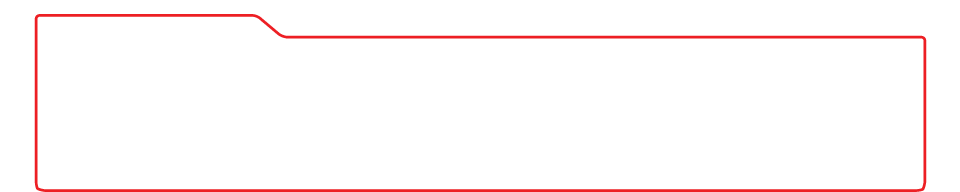
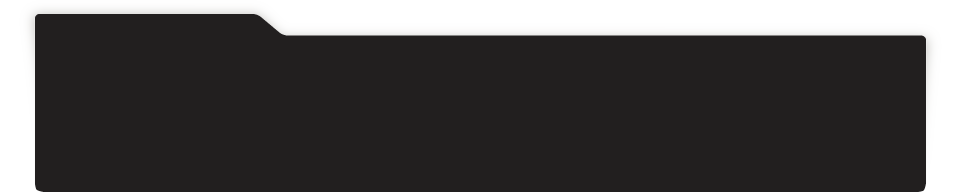
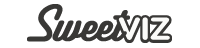
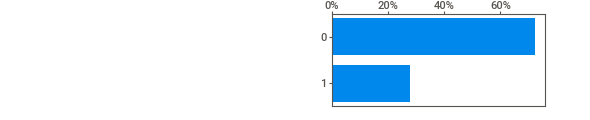
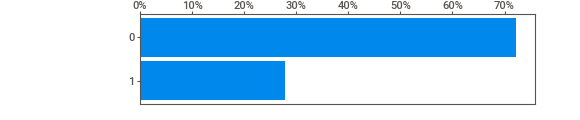
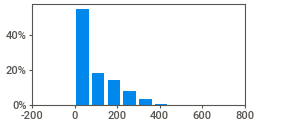
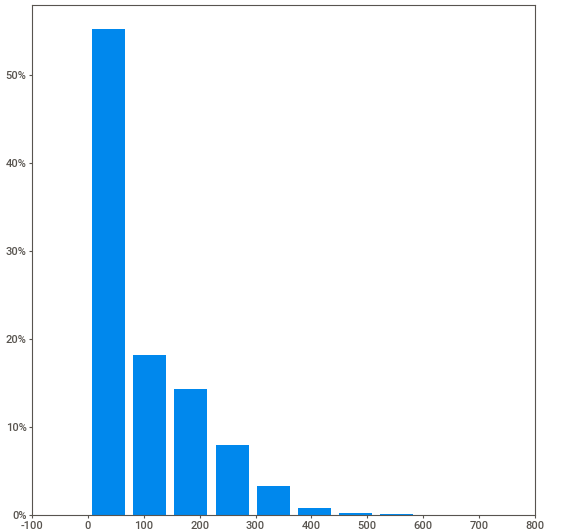
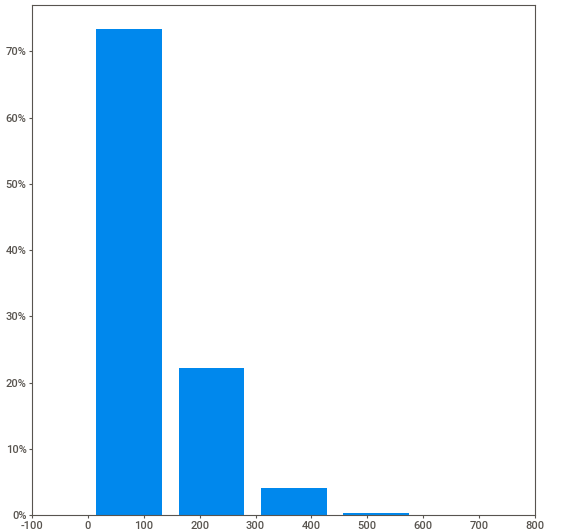
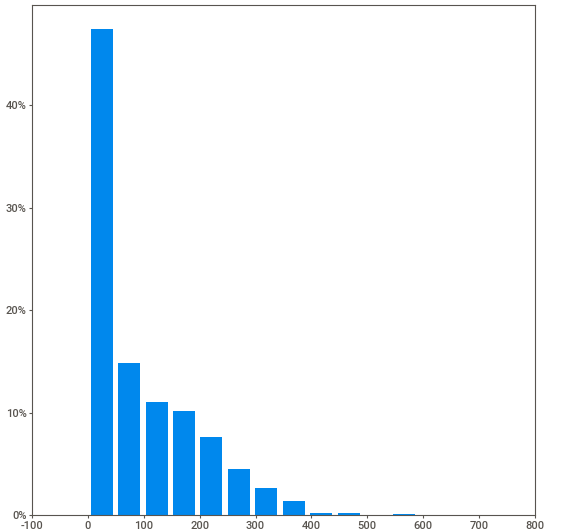
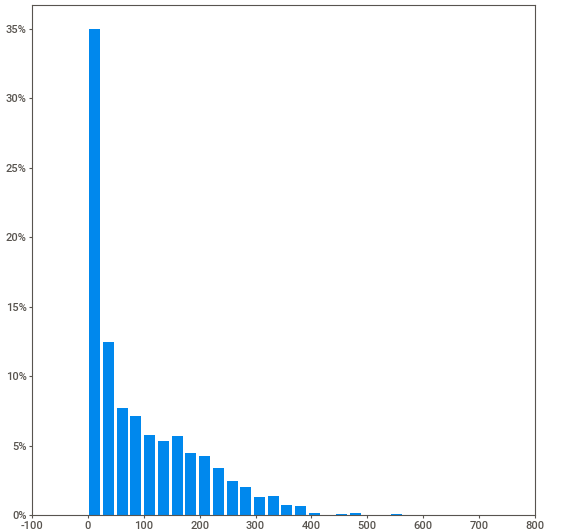
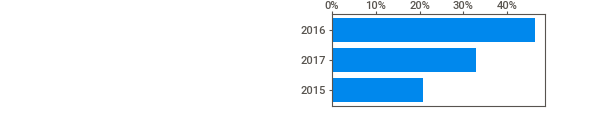
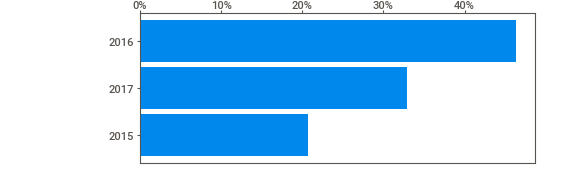
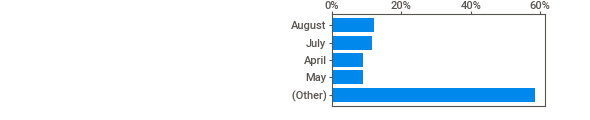
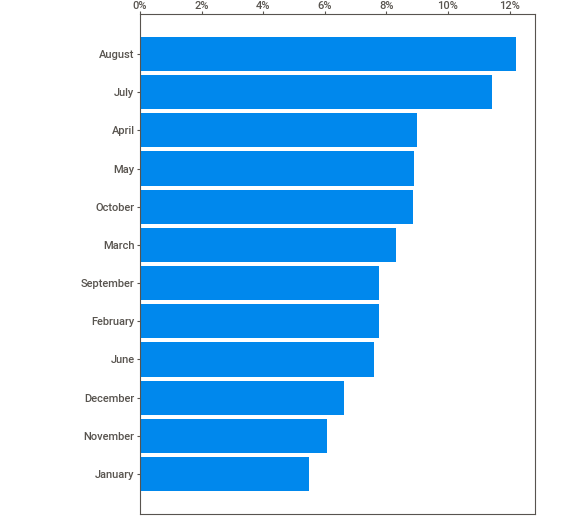
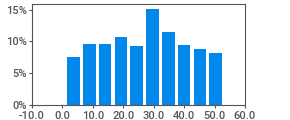
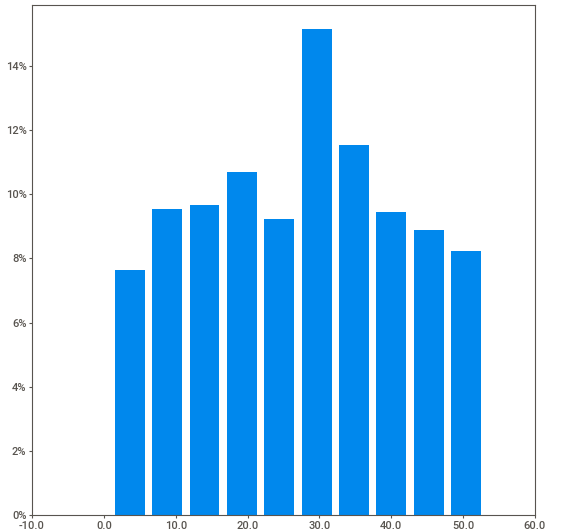
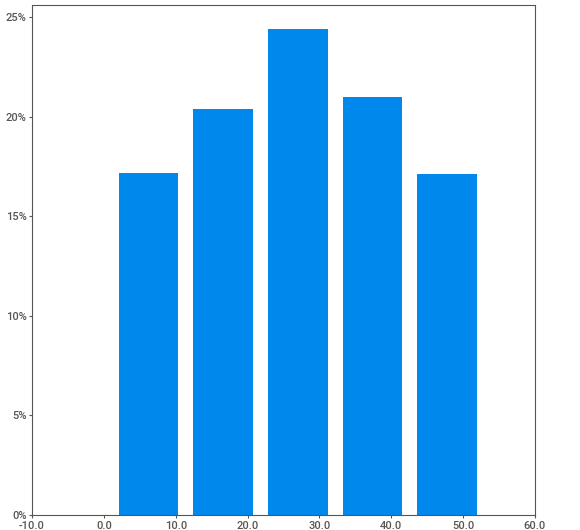
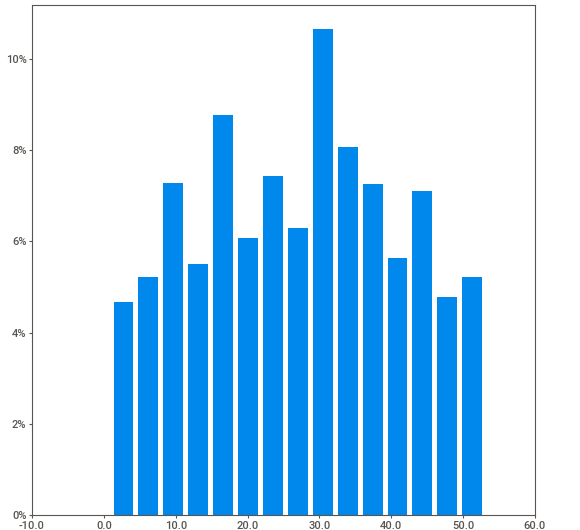
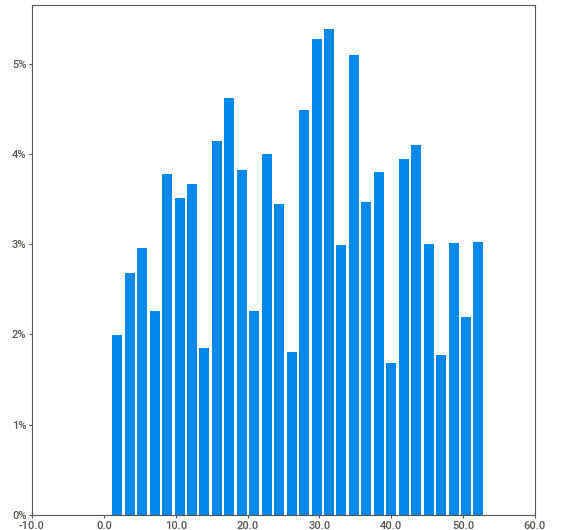
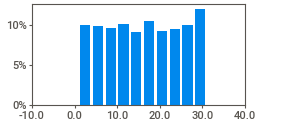
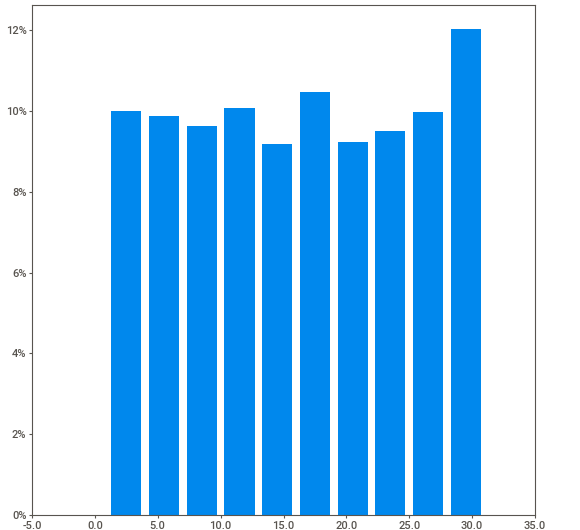
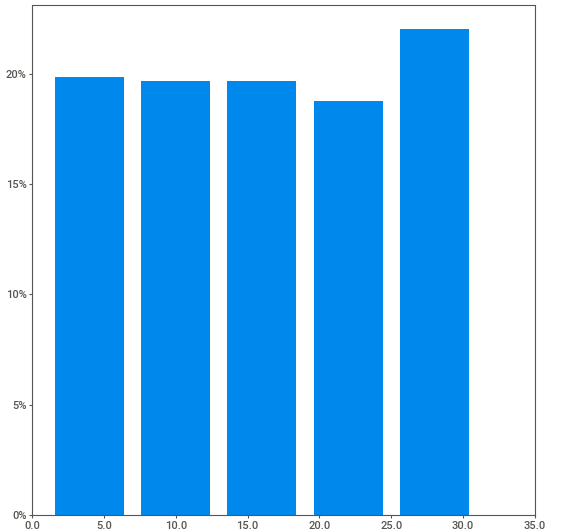
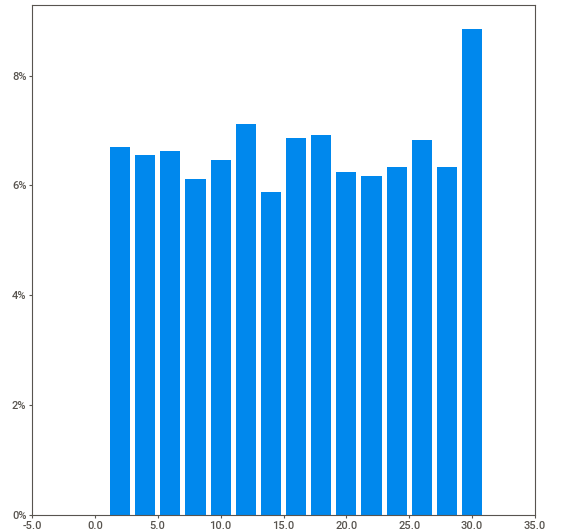
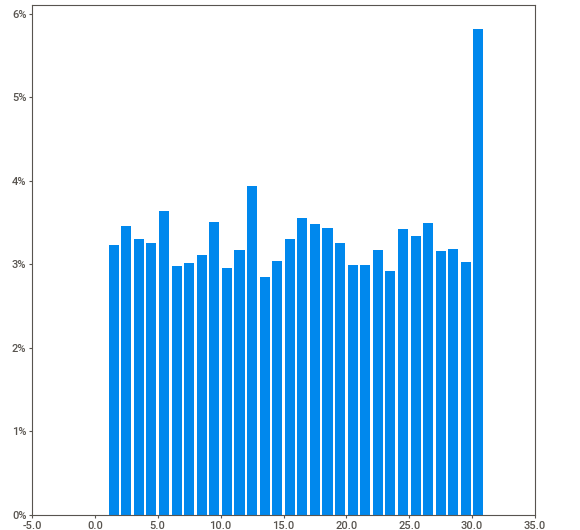
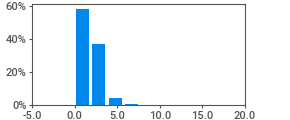
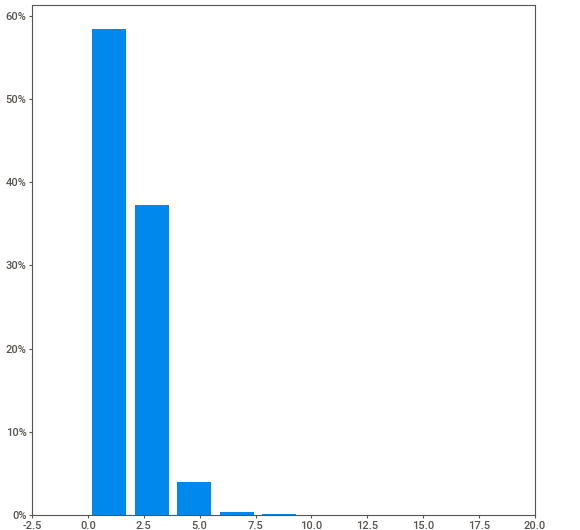
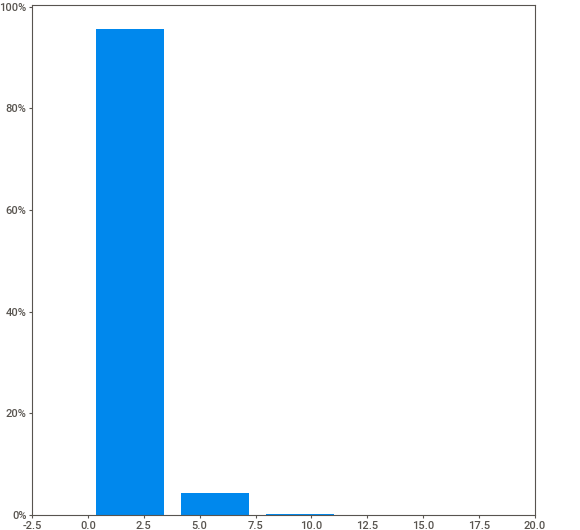
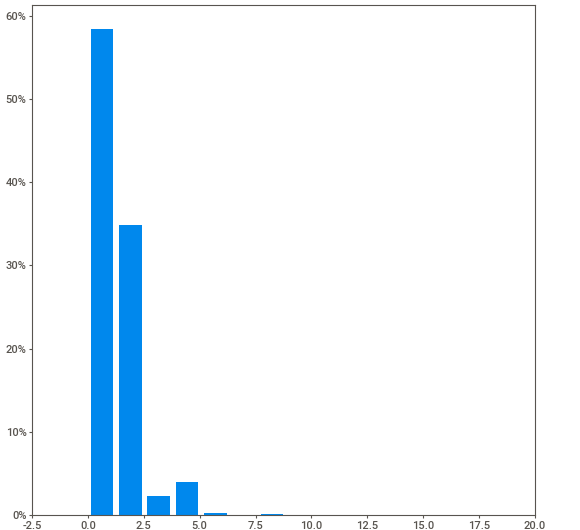
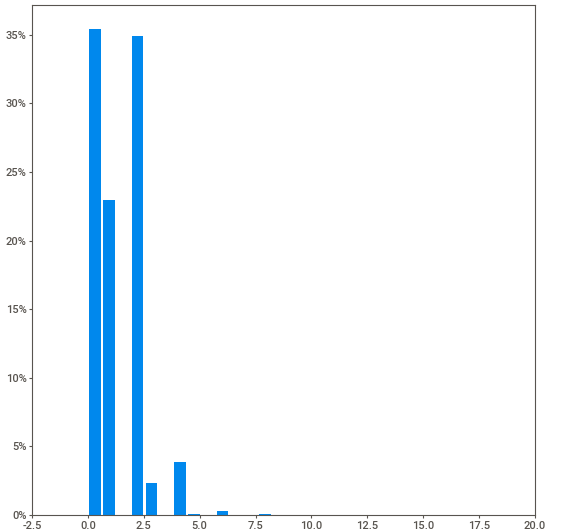
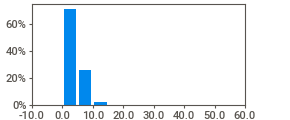
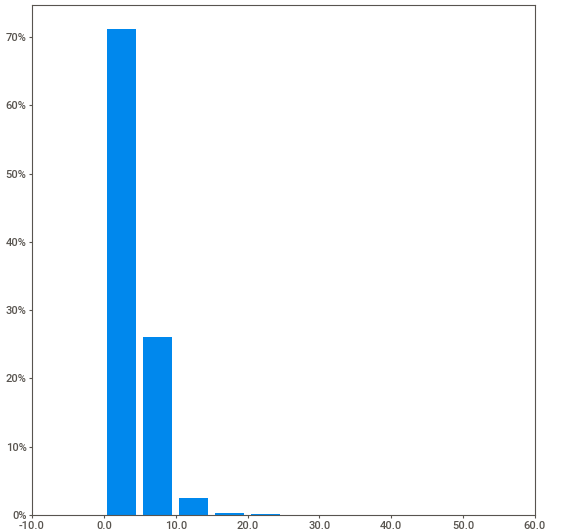
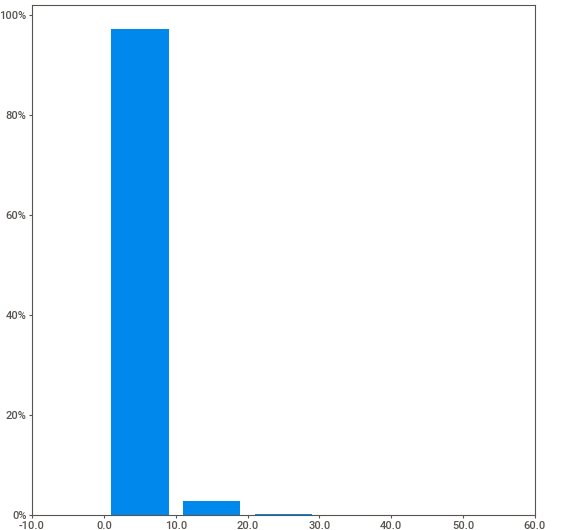
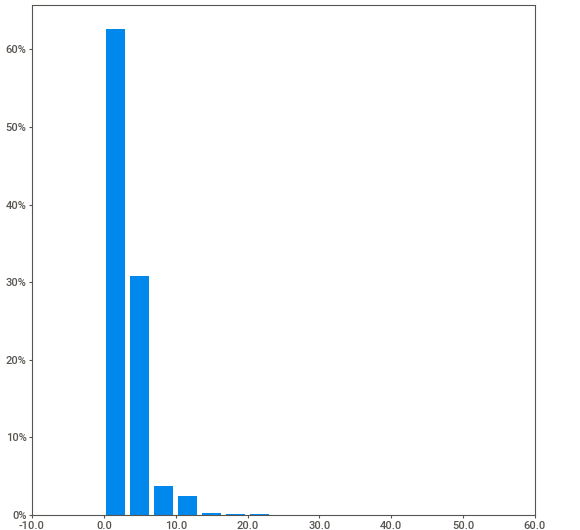
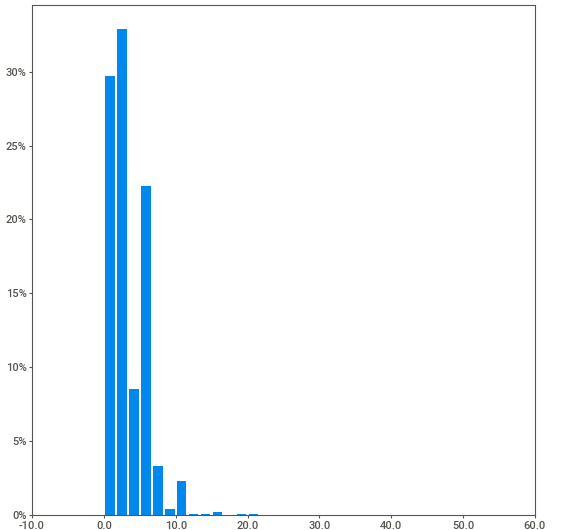
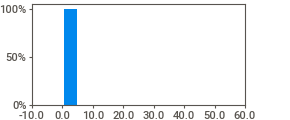
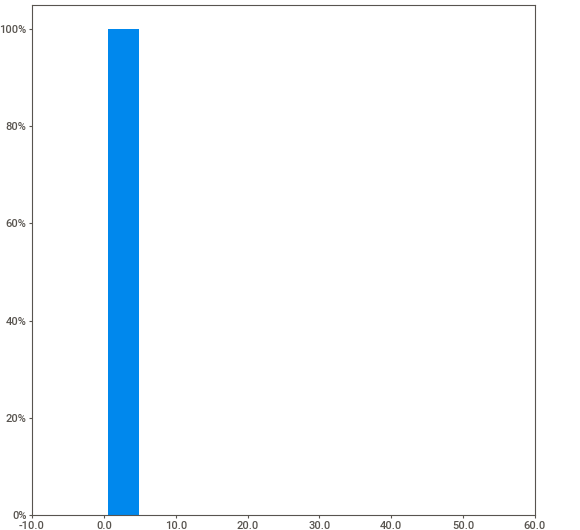
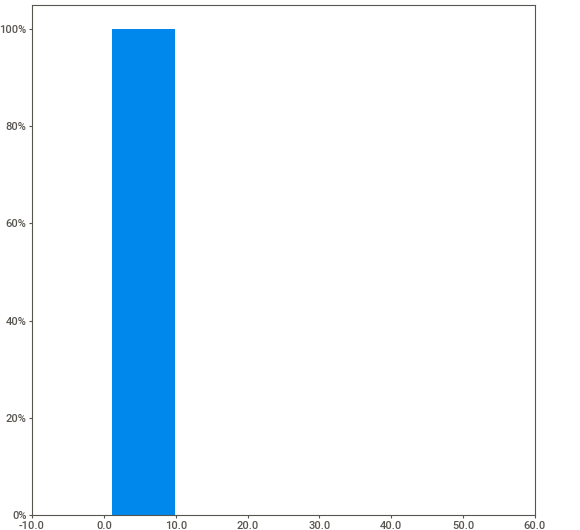
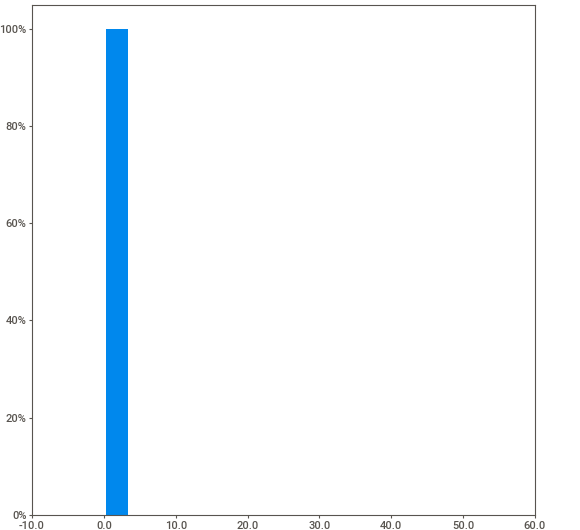
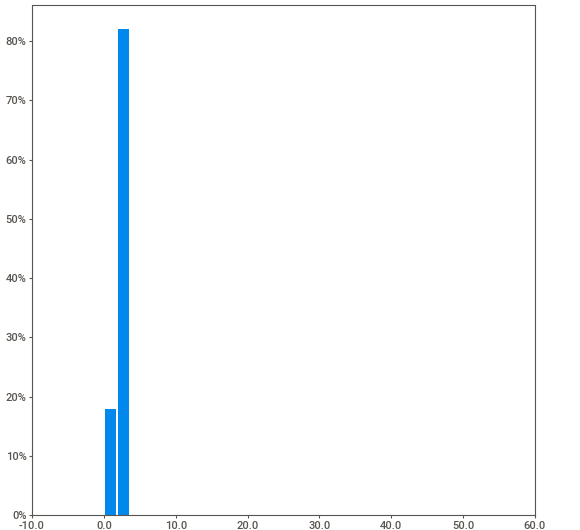
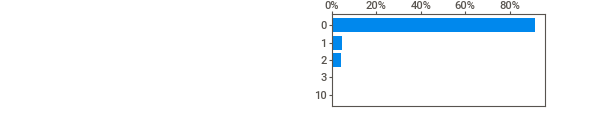
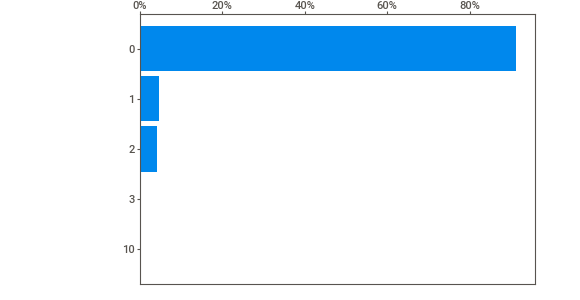
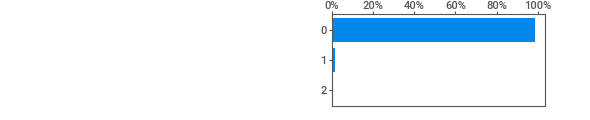
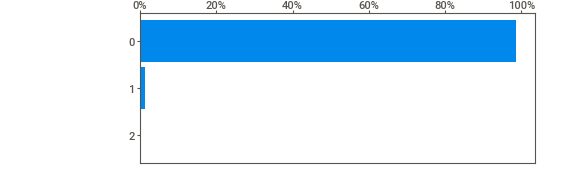
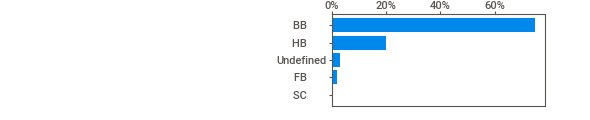
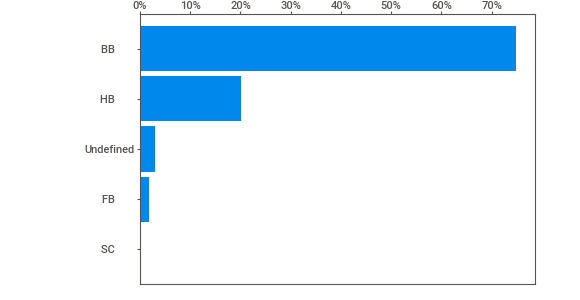
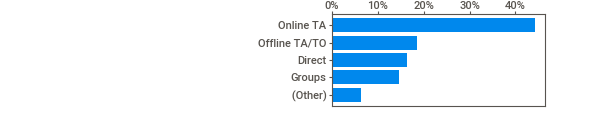
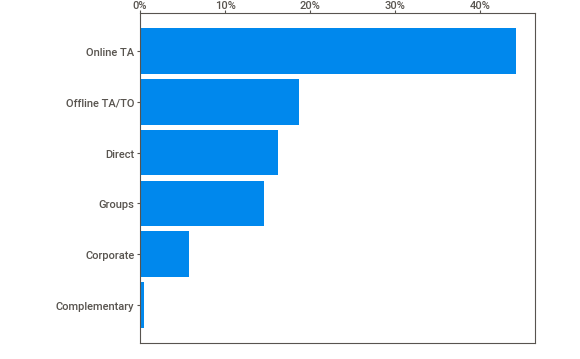
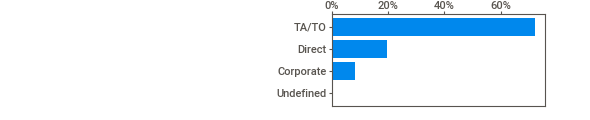
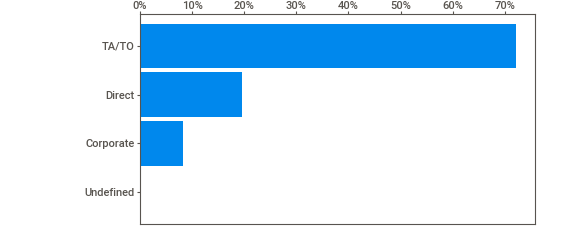
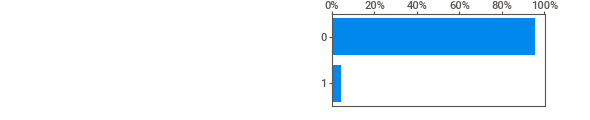
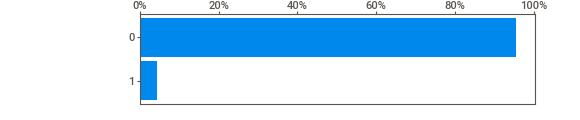
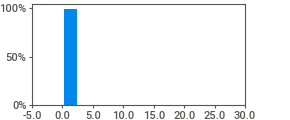
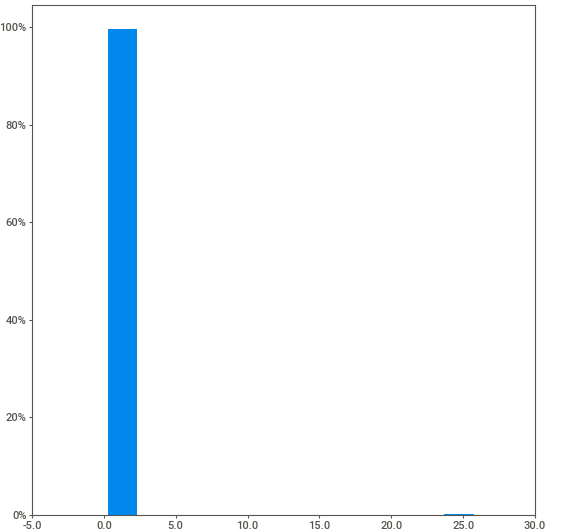
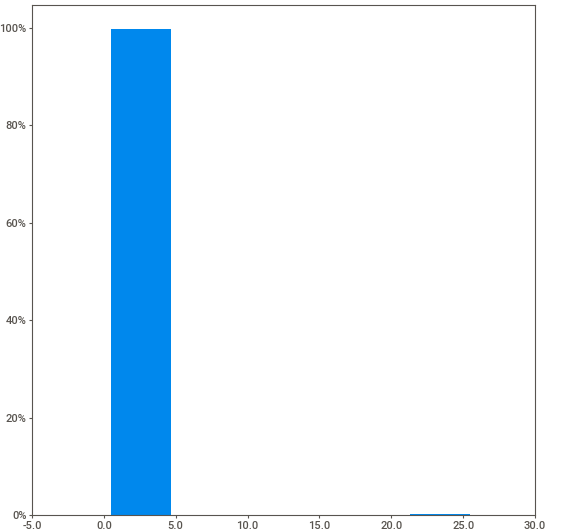
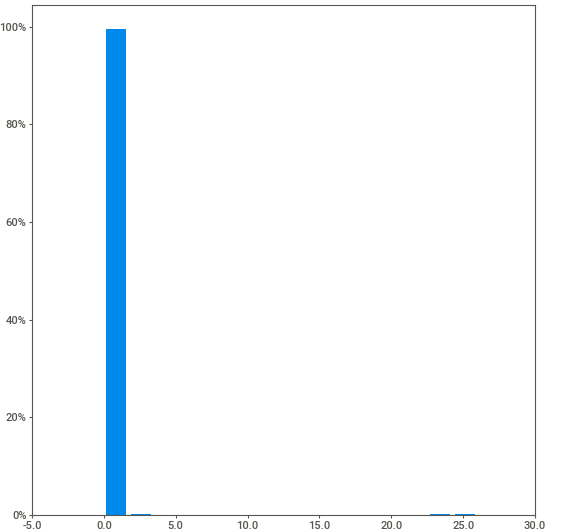
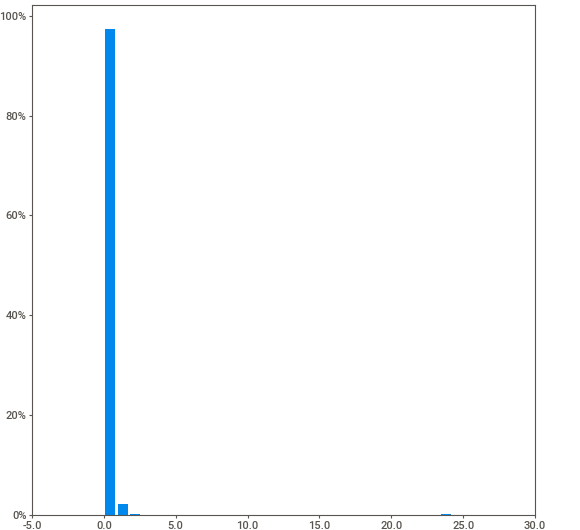
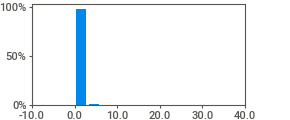
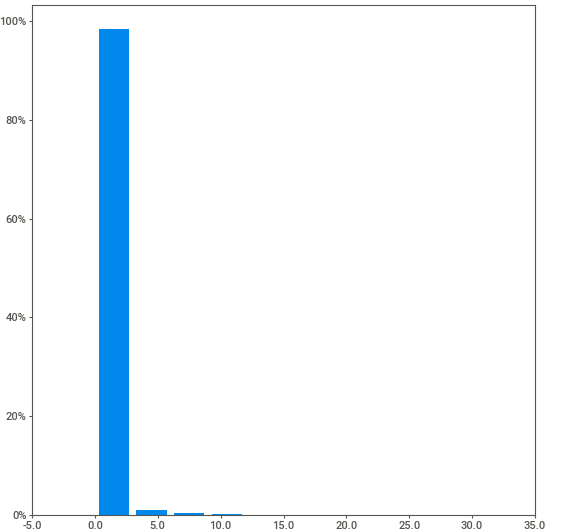
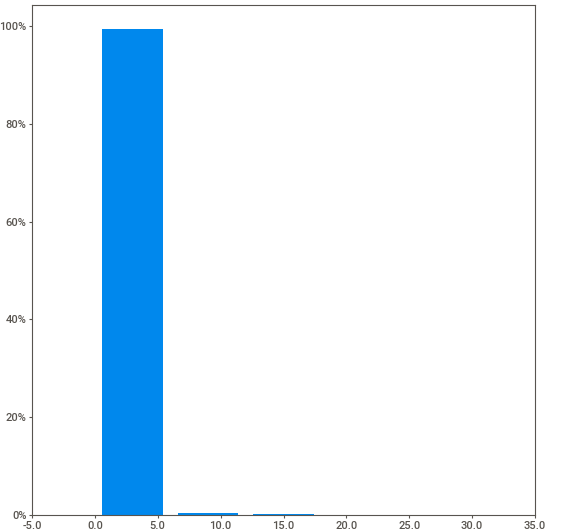
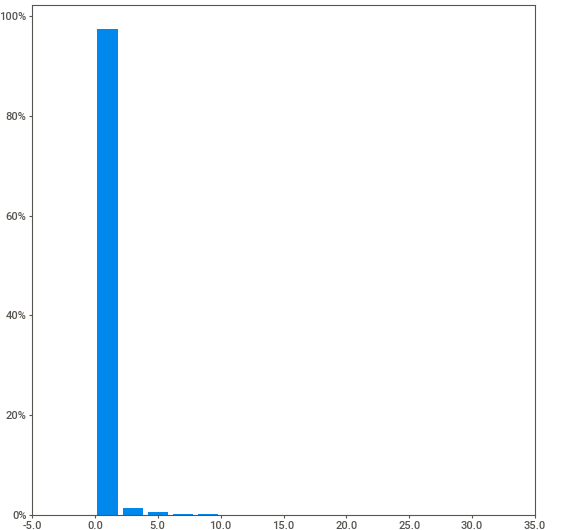
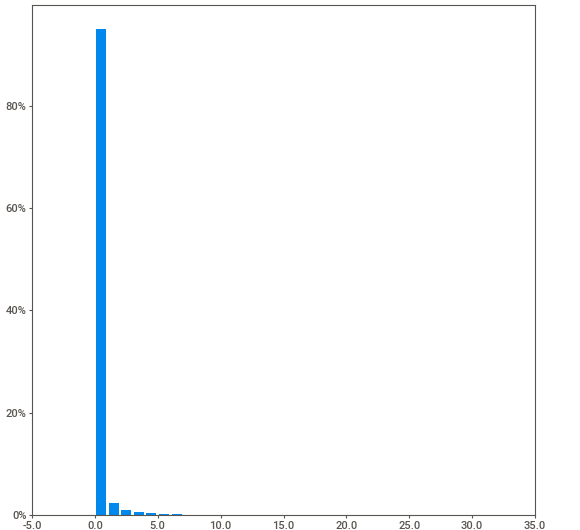
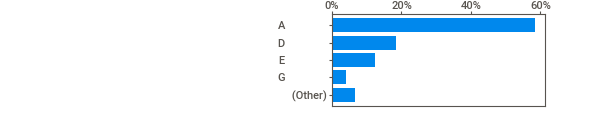
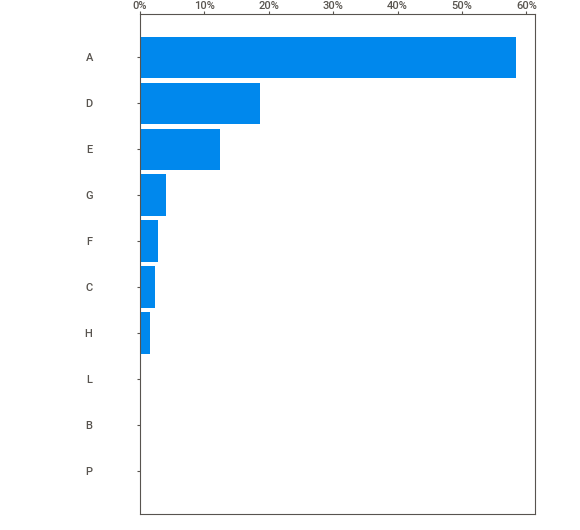
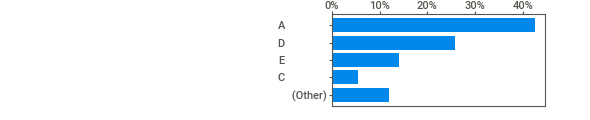
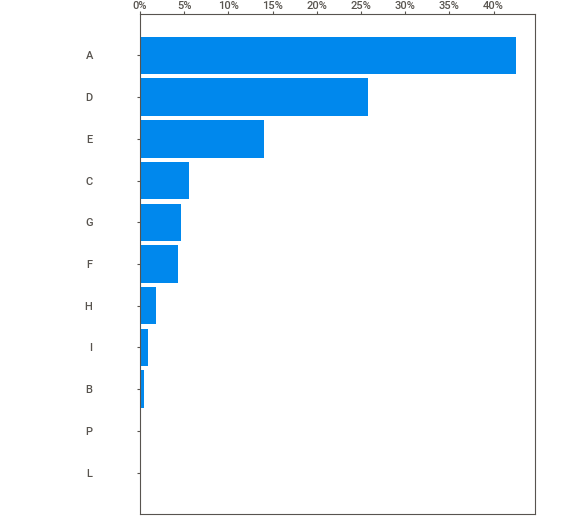
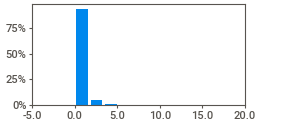
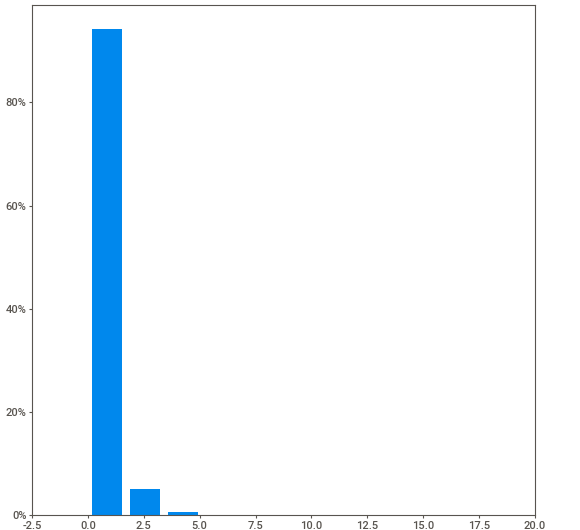
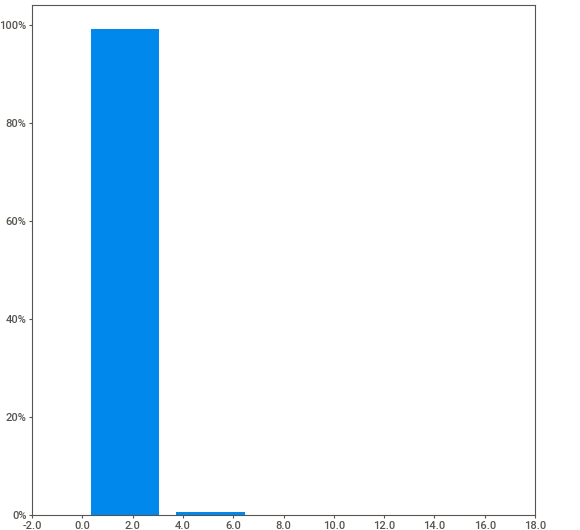
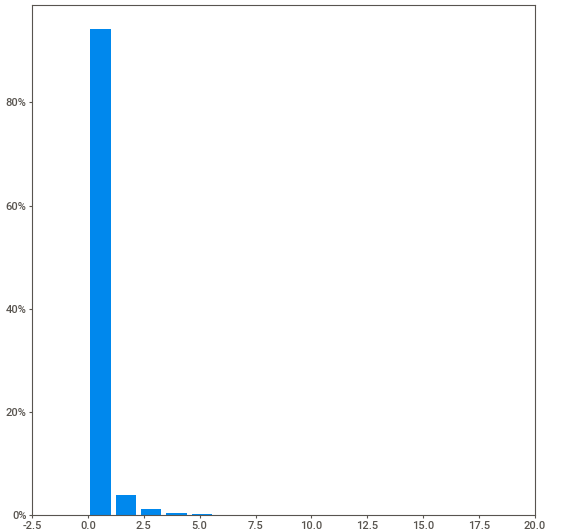
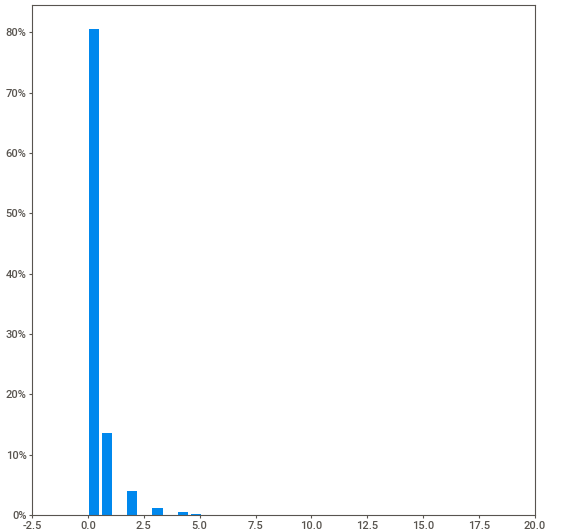
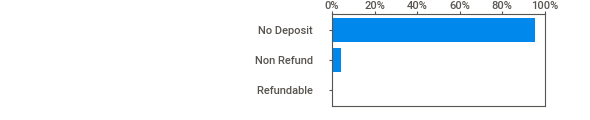
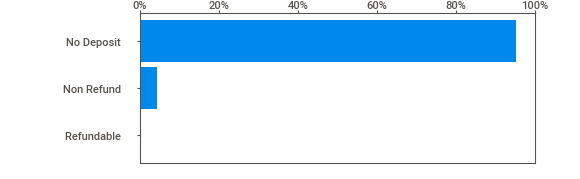
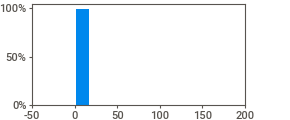
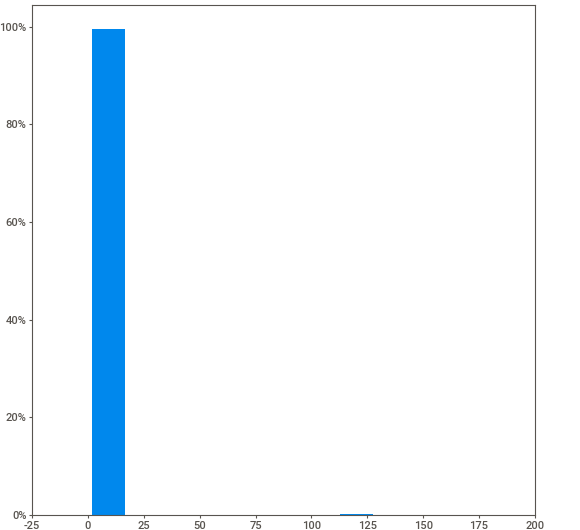
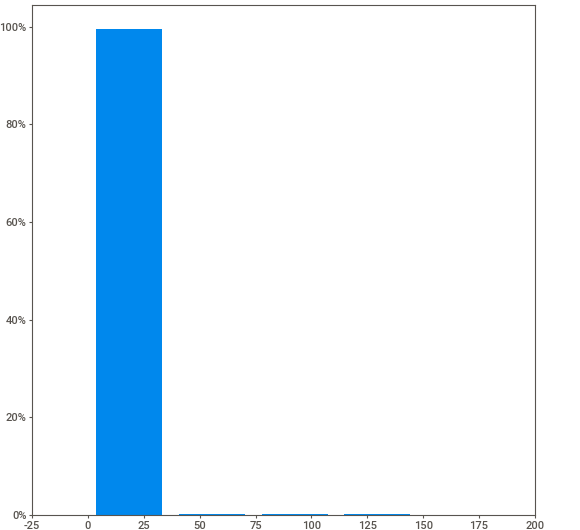
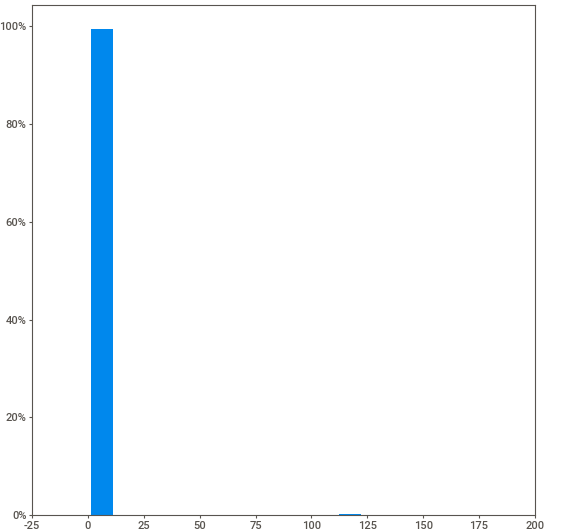
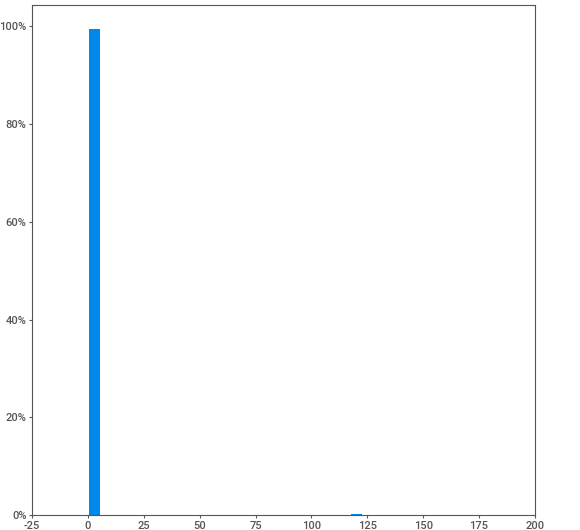
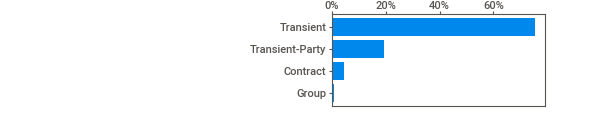
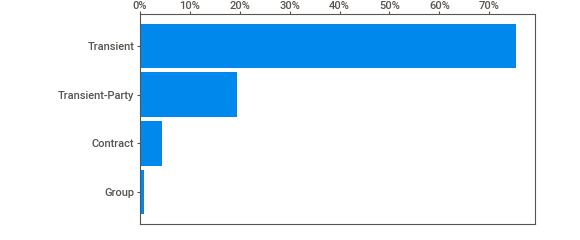
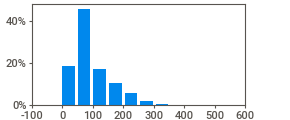
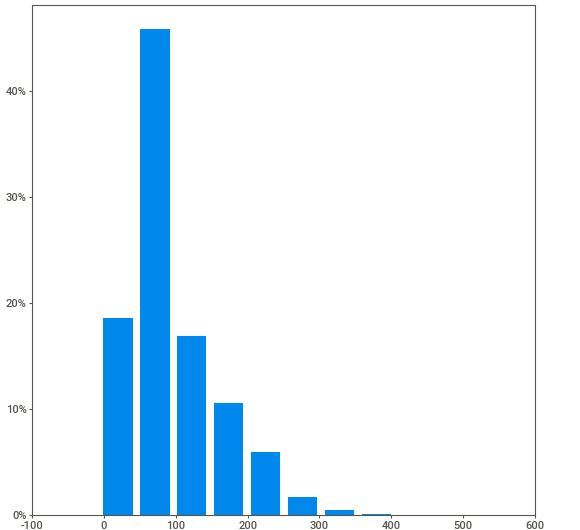
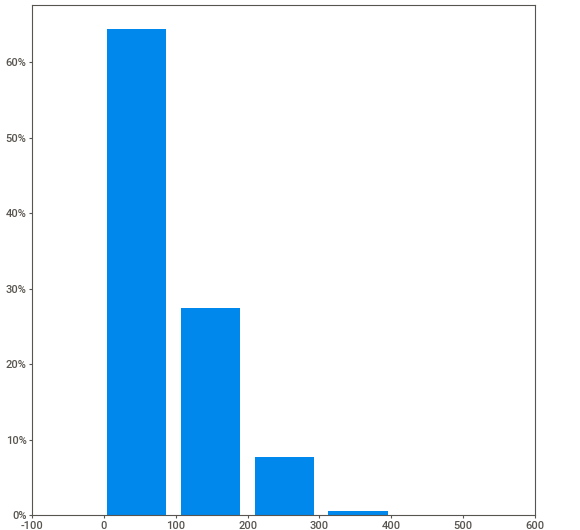
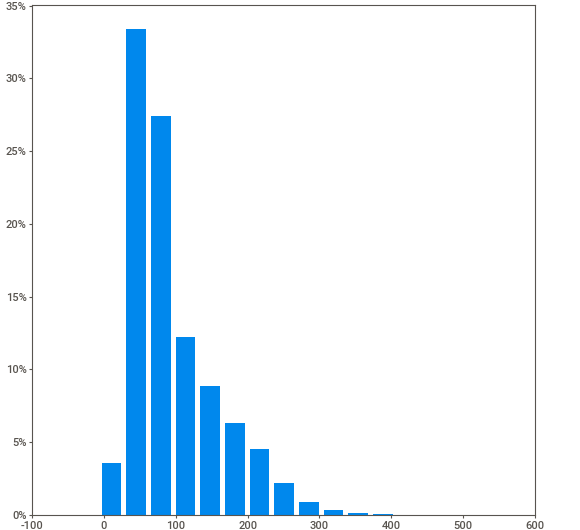
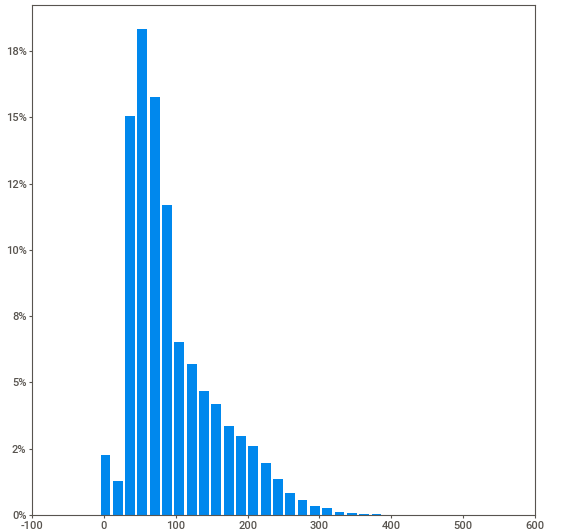
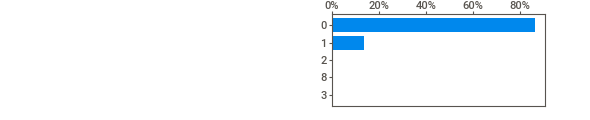
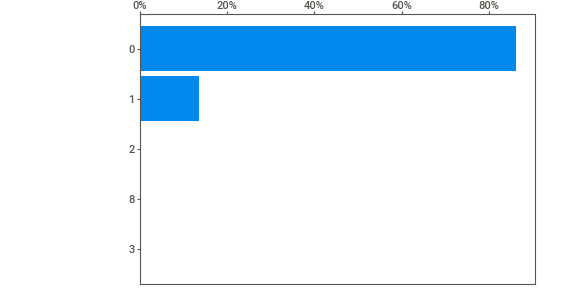
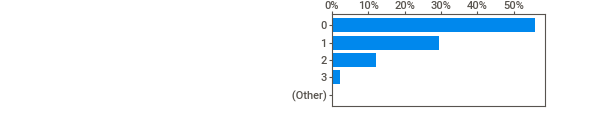
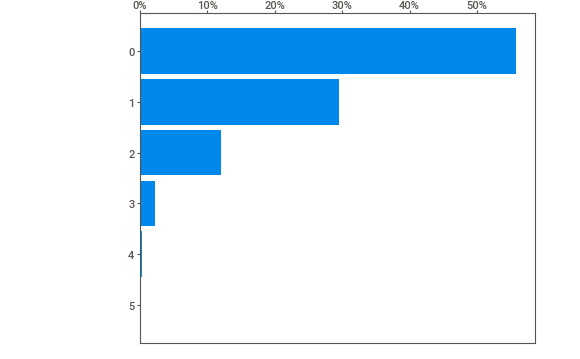
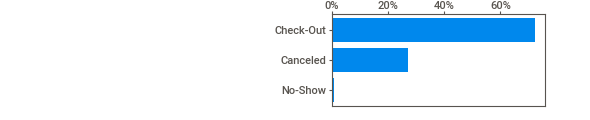
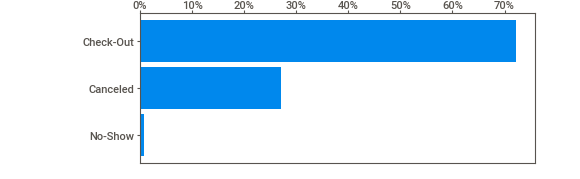
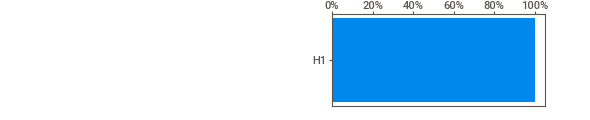
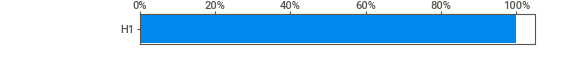

In [3]:
report = sv.analyze(df_h1,pairwise_analysis = 'off')
report.show_notebook()

### **EDA Results**

---

**Feature Review**

1. **IsCanceled**: 
   - **Type**: Binary
   - **Notes**:
      - This feature is too strongly related to the target feature, `ReservationStatus`, and will cause problems for modeling.
         - I will drop this feature after completing my EDA.
      - Imbalanced classification

2. **LeadTime**:
   - **Type**: Numeric, Continuous, all values >= zero
   - **Distribution**: Right-skewed
   - **Action**: Consider applying a Yeo-Johnson transformation to correct skewness, or evaluate whether to drop extreme outliers if they are not representative of typical booking patterns.

3. **Date Features** (e.g., ArrivalDate, DepartureDate):
   - **Type**: DateTime
   - **Action**: Move these features to the feature engineering phase for generating time series details, such as day of the week, month, or seasonality effects.

4. **Adults, Children, Babies**:
   - **Type**: Numeric, Discrete
   - **Distribution**: Right-skewed
   - **Action**: Evaluate the necessity of transforming these features to reduce skewness or consider removing outliers that could distort the analysis (e.g. 55 adults).

5. **Meal**:
   - **Type**: Categorical
   - **Action**: Perform encoding during the modeling pipeline preprocessing to convert this feature into a format suitable for machine learning models.

6. **Country**:
   - **Type**: Categorical
   - **Action**: Encode this feature during preprocessing. Given the high cardinality (many unique countries), consider using a method that reduces dimensionality, such as frequency encoding or grouping similar countries.

7. **PreviousCancellations / PreviousBookingsNotCancelled**:
   - **Type**: Numeric, Discrete
   - **Notes**: These features are particularly useful for post-booking forecasts but are less applicable for pre-booking revenue forecasting. Their predictive power might be more relevant to behavioral analysis after a booking is made.

8. **BookedRoomType / AssignedRoomType**:
   - **Type**: Categorical
   - **Notes**: The `AssignedRoomType` is not known until after the stay, which makes it a candidate for feature engineering. You could explore classification models to predict the assigned room type or analyze the matching between booking and assignment.

9. **BookingChanges**:
   - **Type**: Numeric, Discrete
   - **Distribution**: Right-skewed
   - **Action**: Plan to transform this feature during preprocessing to manage skewness.

10. **DepositType**:
    - **Type**: Categorical
    - **Action**: Perform encoding during preprocessing.

11. **Agent, Company**:
    - **Type**: Categorical
    - **Action**: These features require encoding during preprocessing. Given potential high cardinality, consider using frequency encoding or similar techniques.
    - **Action**: Convert "NULL" string to actual null values, then fill during preprocessing. Presence of missing values may be informative.

12. **DaysInWaitingList**:
    - **Type**: Numeric, Discrete
    - **Distribution**: Right-skewed
    - **Action**: This feature should be transformed during preprocessing to reduce skewness.

13. **ADR (Average Daily Rate)**:
    - **Type**: Numeric, Continuous
    - **Notes**: While no longer the target feature, ADR remains an important predictor. It has negative values that should be examined—decide whether to retain, drop, or adjust these values (e.g., bringing all values above zero). ADR is also right-skewed and could benefit from transformation (e.g., log or Yeo-Johnson) during preprocessing.

14. **RequiredParkingSpaces**:
    - **Type**: Numeric, Discrete
    - **Distribution**: Right-skewed
    - **Action**: Apply transformation during preprocessing to manage skewness.

15. **ReservationStatus** (Target Feature):
    - **Type**: Categorical
    - **Notes**: This feature indicates the final status of a reservation (e.g., canceled, checked-in, no-show). It is the target for classification modeling. It's important to avoid data leakage by ensuring that no features derived from this status are used inappropriately.

16. **ReservationStatusDate**:
    - **Type**: DateTime
    - **Action**: Utilize this feature in temporal feature engineering, such as calculating the time between booking and status change, or deriving features related to the timing of the status update.

---

 **Review Summary**

- **Numeric Features**: Several numeric features exhibit right-skewness and contain extreme outliers. These characteristics suggest that transformations, such as Yeo-Johnson, could be beneficial. However, in some cases, it may be appropriate to drop extreme outliers if they do not represent typical data patterns.

- **Categorical Features**: Many categorical features, especially those with high cardinality (e.g., `Country`, `Agent`, `Company`), will need encoding. To avoid the dimensionality explosion that comes with one-hot encoding, techniques like frequency encoding or grouping should be considered.

- **Multicollinearity**: Multicollinearity is a concern, particularly for linear models. It will be essential to evaluate and potentially remove highly correlated features using methods such as Variance Inflation Factor (VIF) analysis.

- **Target Feature (ReservationStatus)**: The target for classification, `ReservationStatus`, needs to be compared against the boolean `IsCanceled` column to ensure no-show reservations are marked as cancellations.

---

**Next Steps**

- **Outliers and Skewness**: Apply transformations such as Yeo-Johnson during the preprocessing phase to address skewness in numeric features. Consider dropping extreme outliers if they do not contribute meaningful information.

- **Categorical Encoding**: Implement encoding for categorical features during the modeling pipeline, focusing on methods that manage high cardinality, such as CountFrequencyEncoder.

- **Address Multicollinearity**: For linear models, use VIF analysis or similar methods to detect and mitigate multicollinearity among features.

- **Feature Engineering**: Incorporate time-based features and engineered features derived from `ReservationStatusDate` and other date features to enhance the model's predictive power.

---

## Hotel 2

                                             |          | [  0%]   00:00 -> (? left)


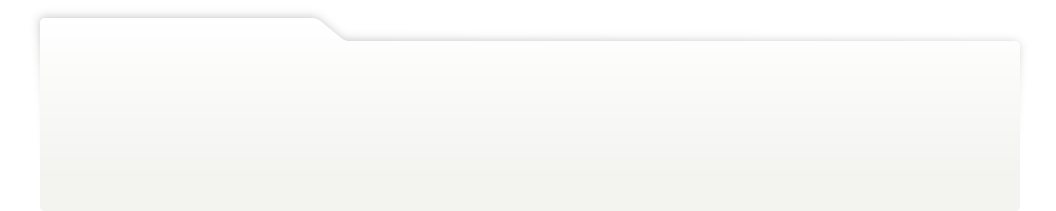
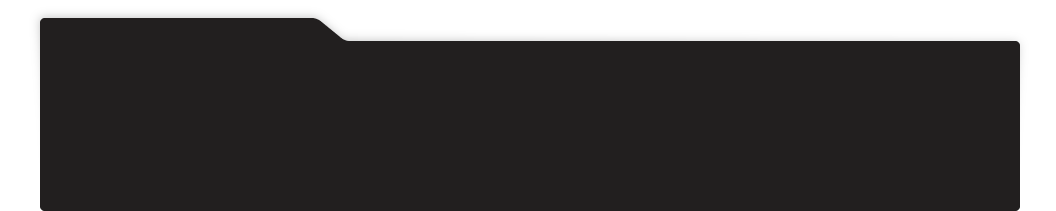
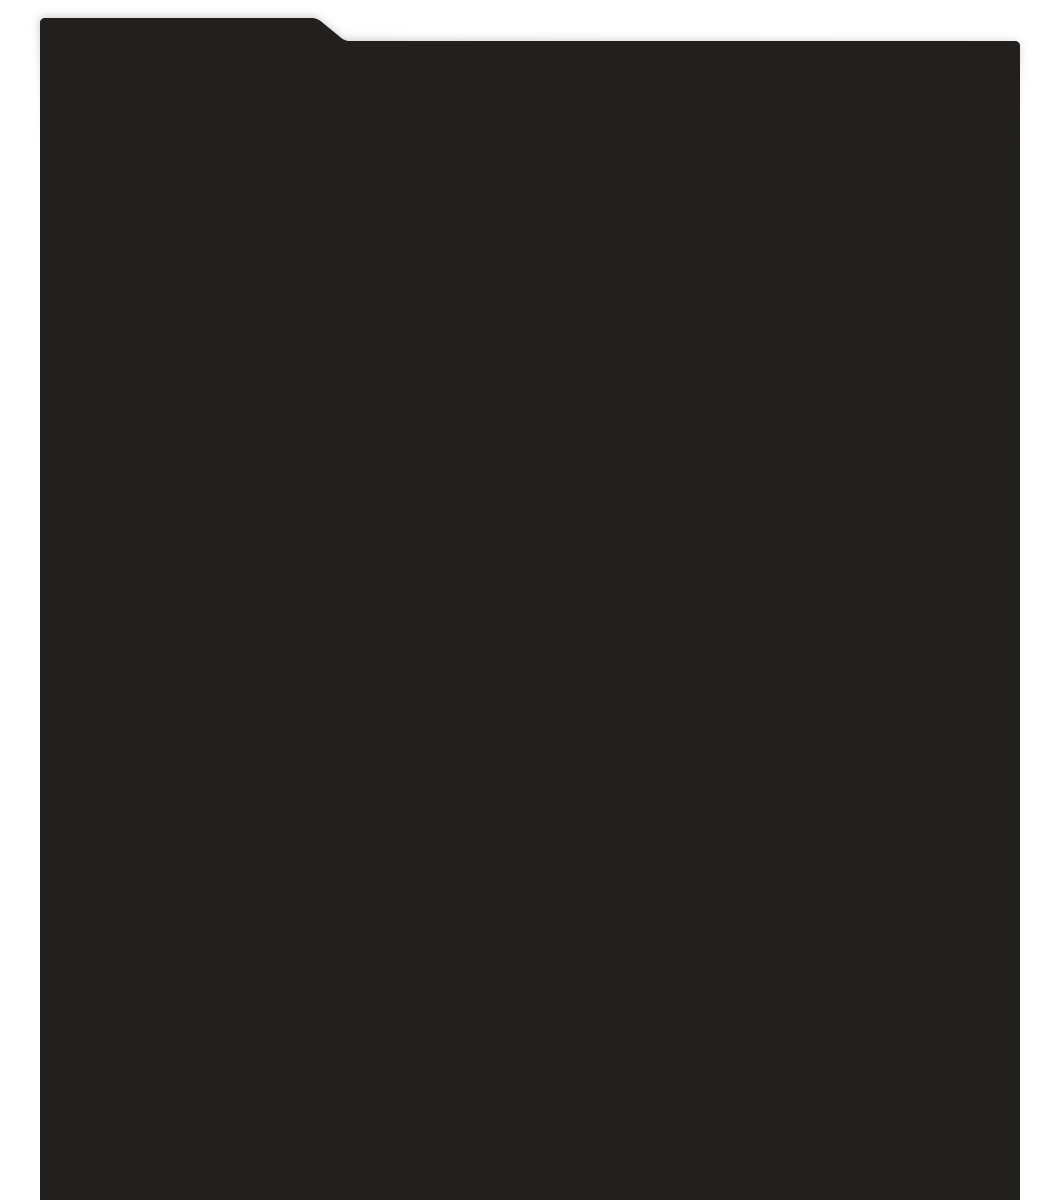
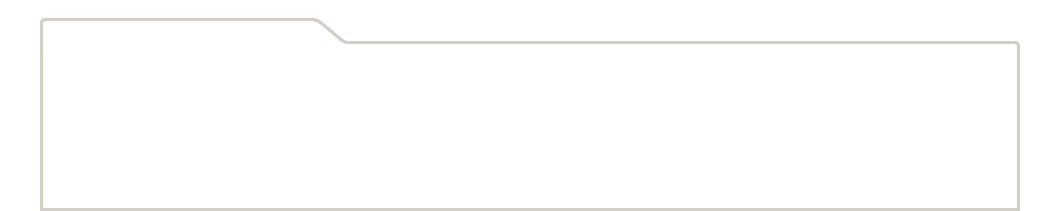
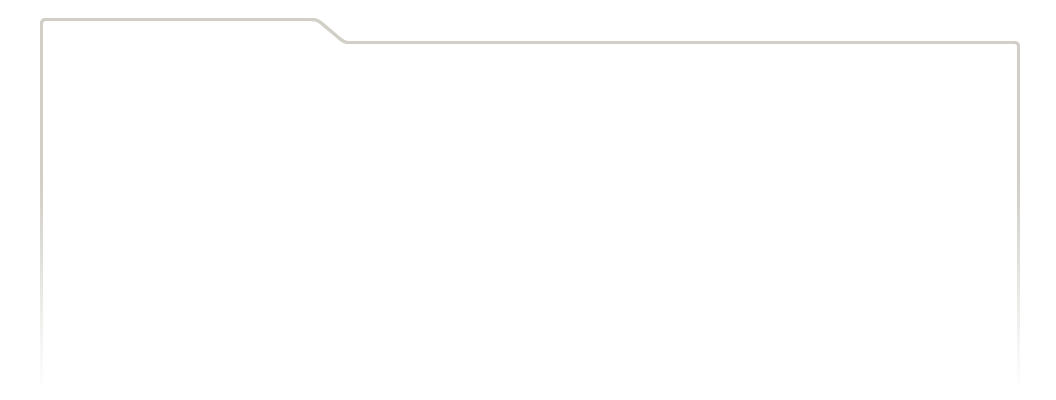
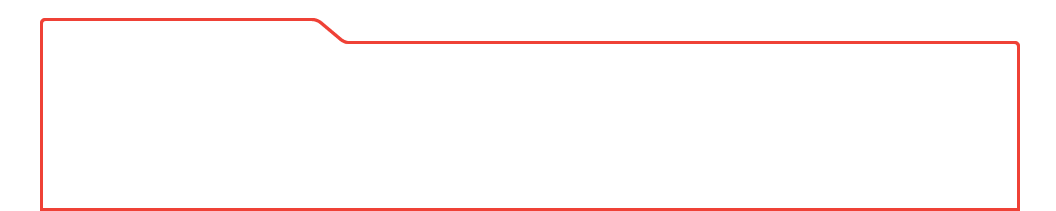
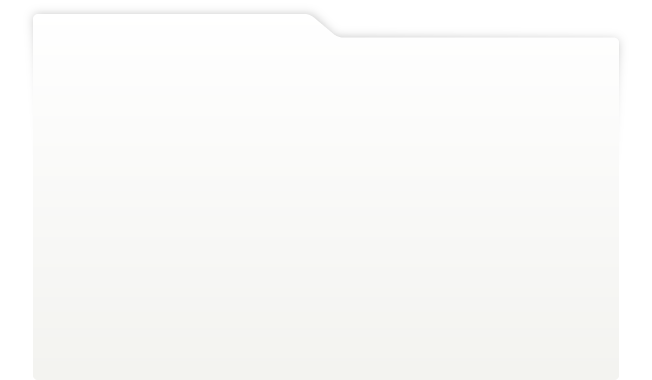
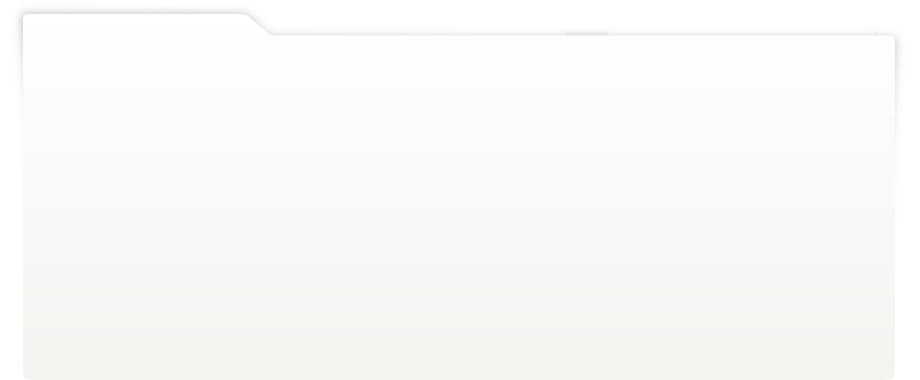
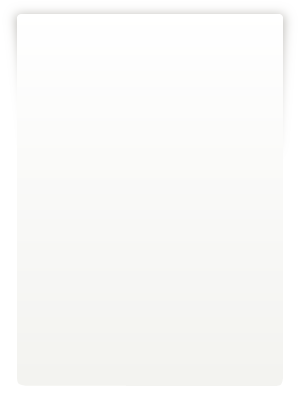
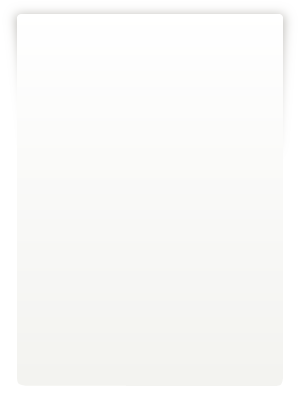
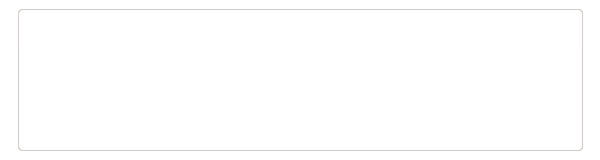
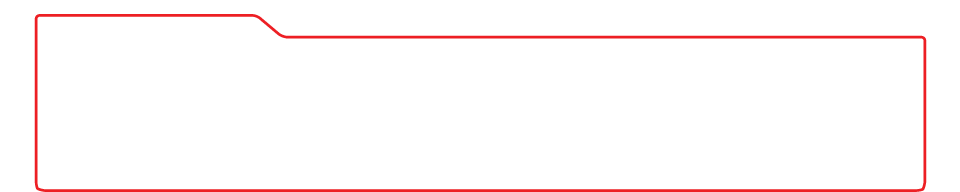
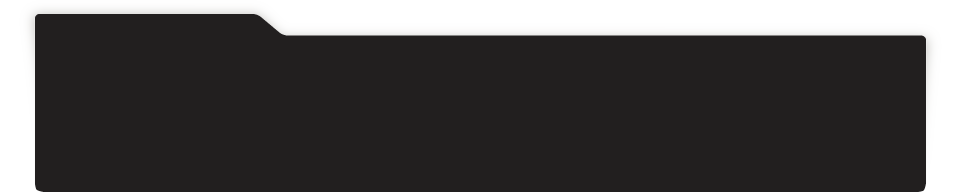
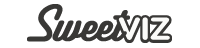
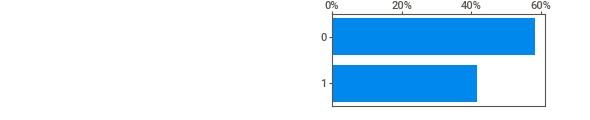
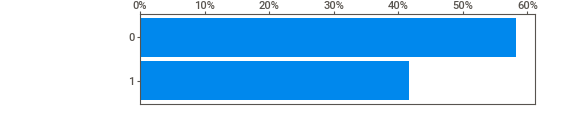
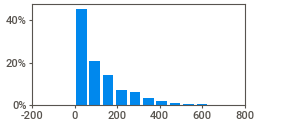
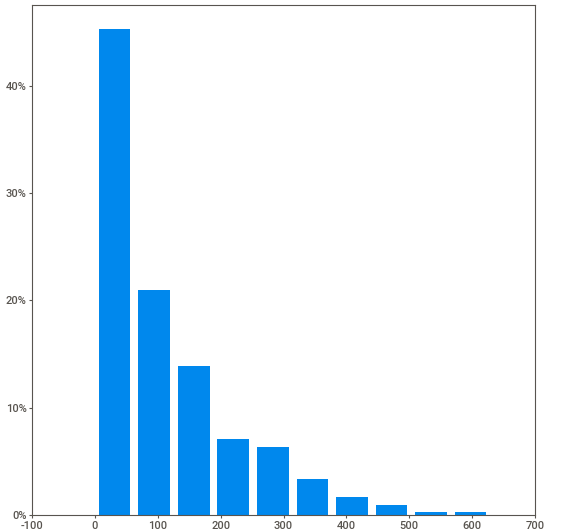
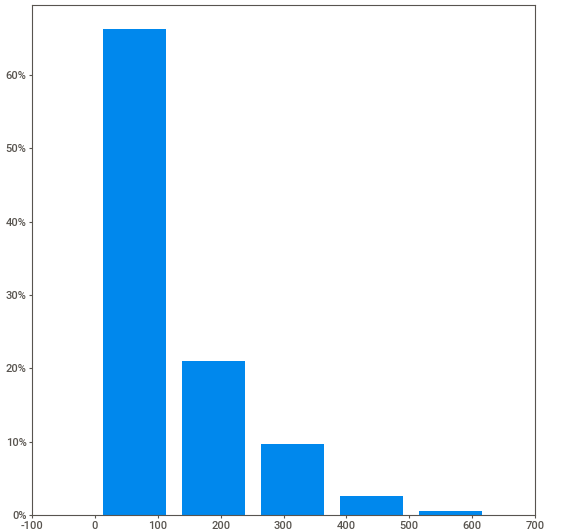
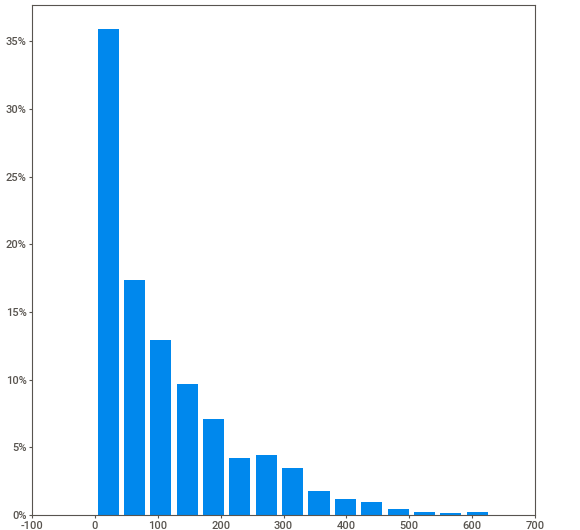
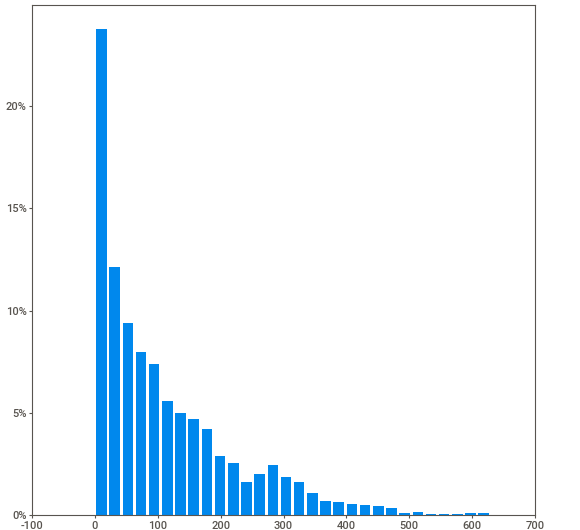
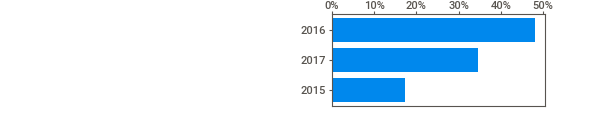
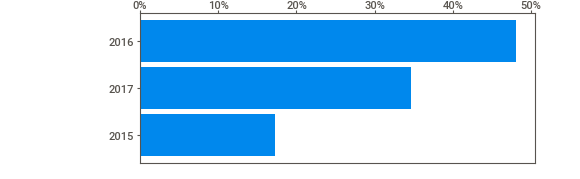
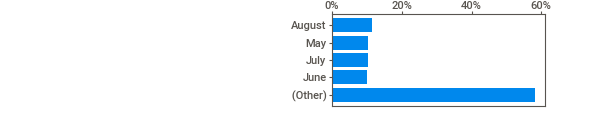
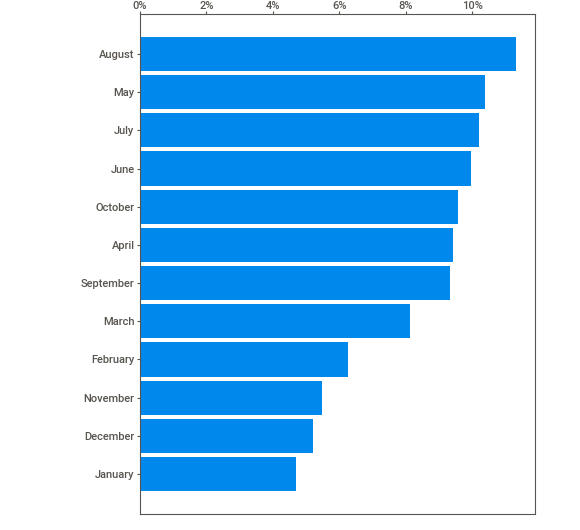
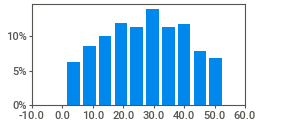
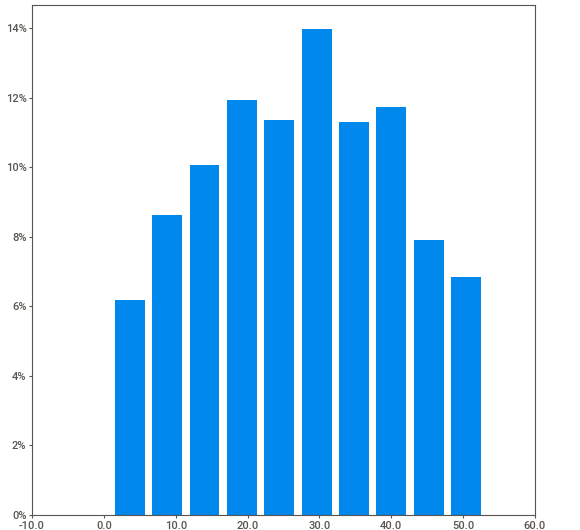
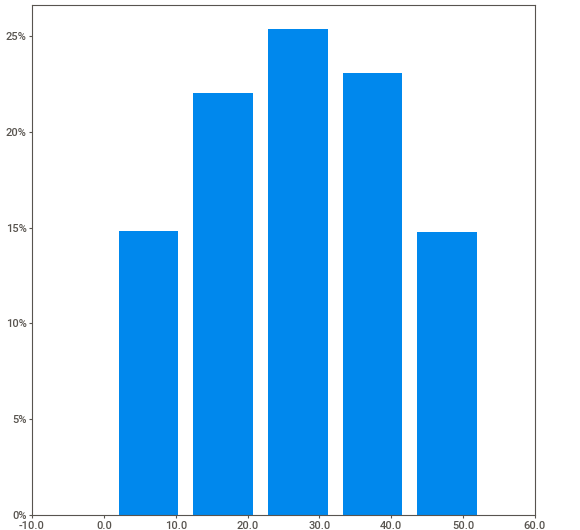
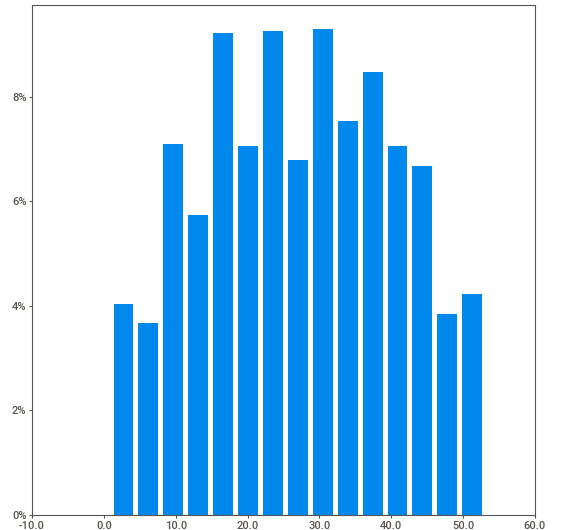
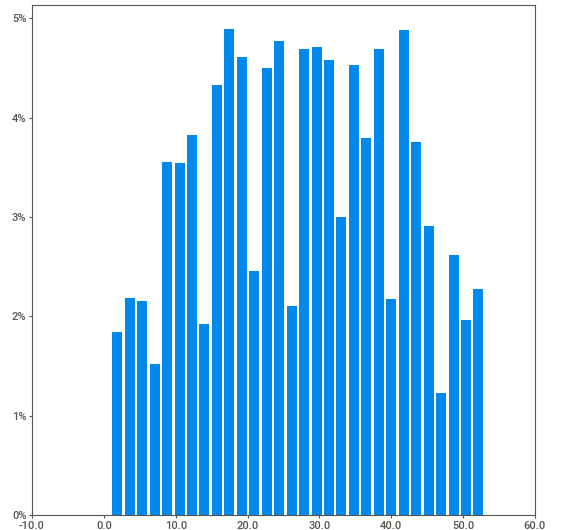
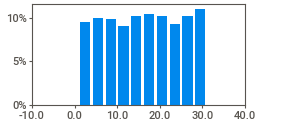
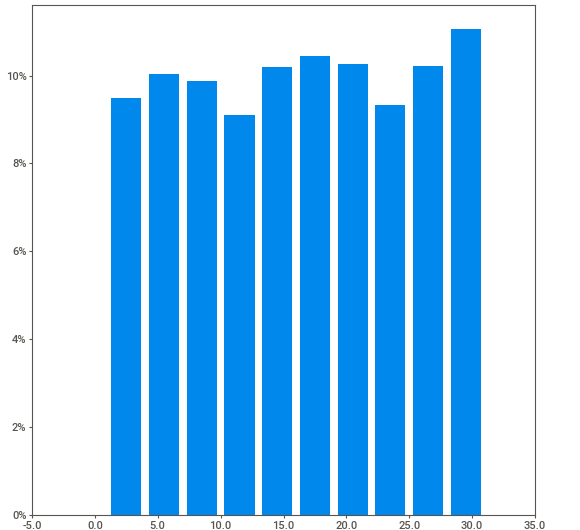
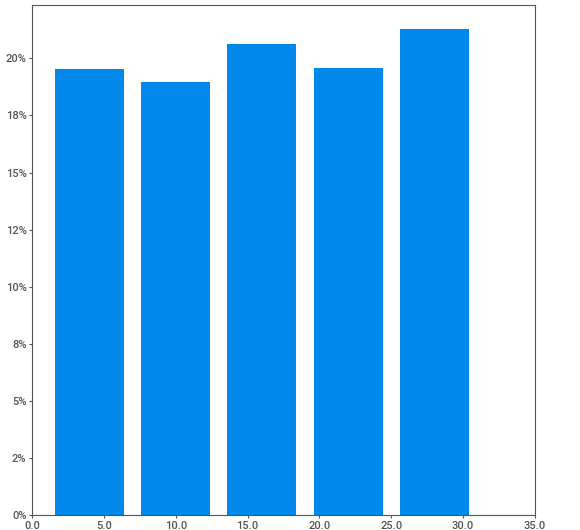
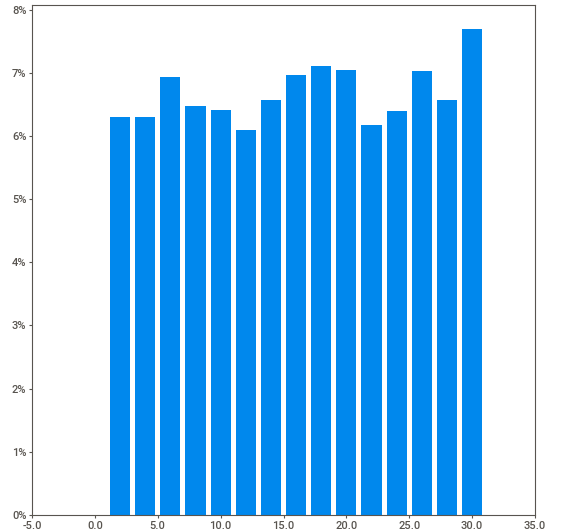
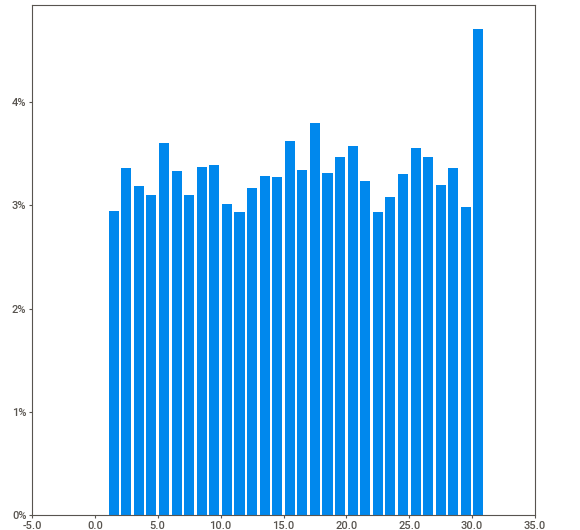
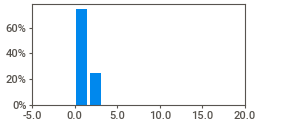
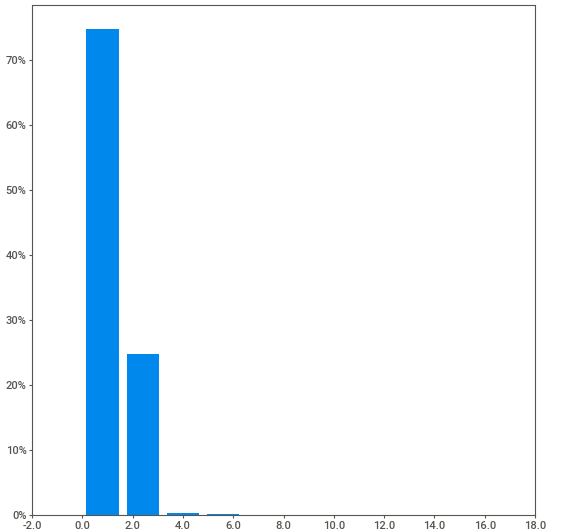
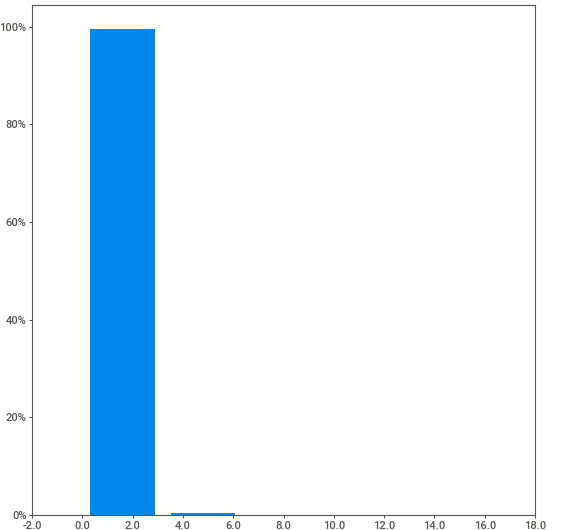
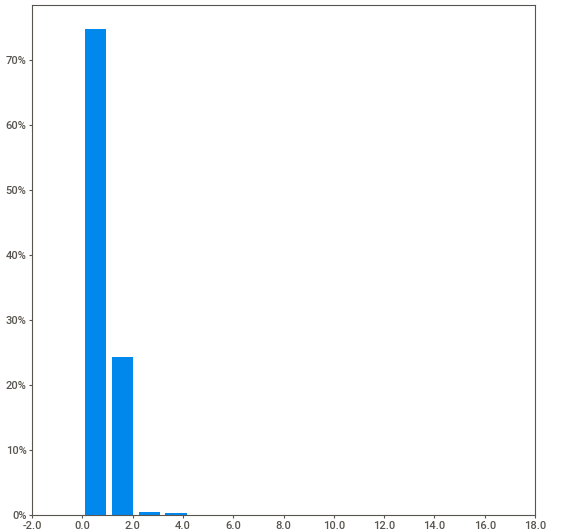
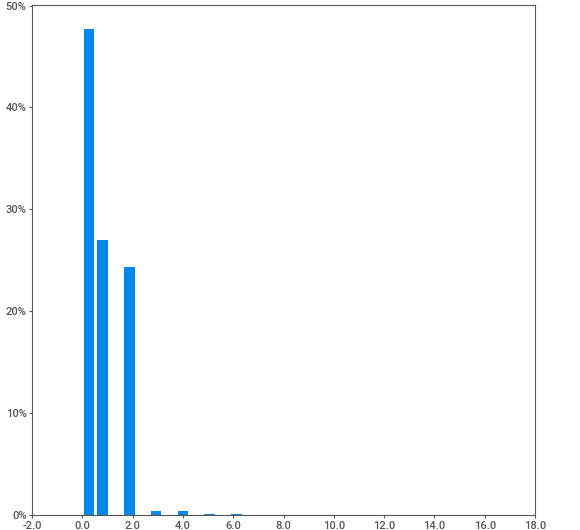
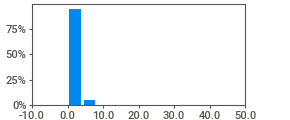
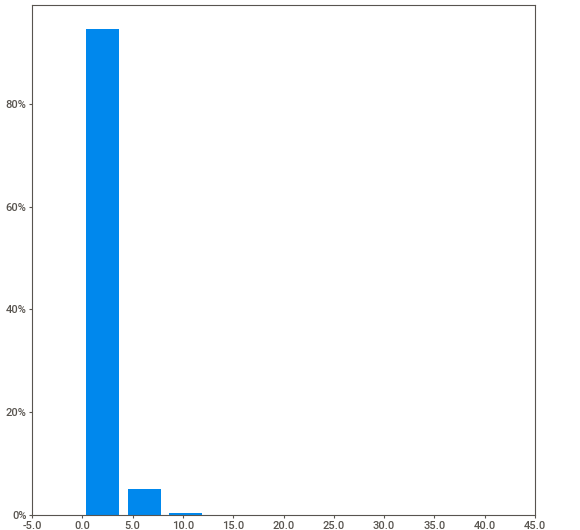
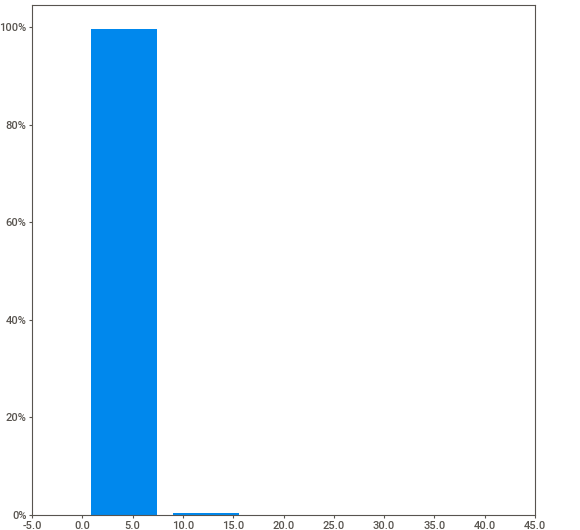
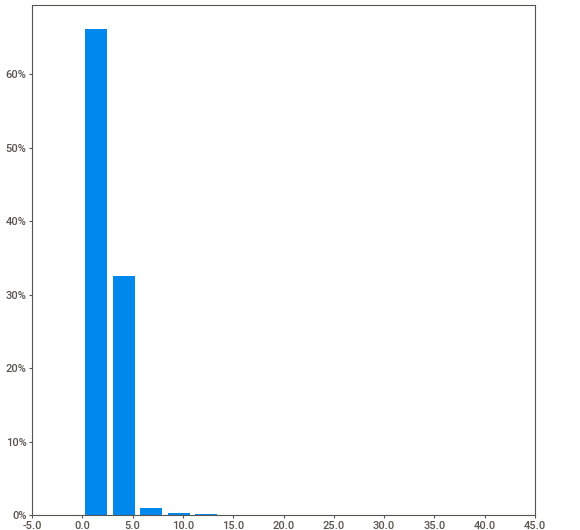
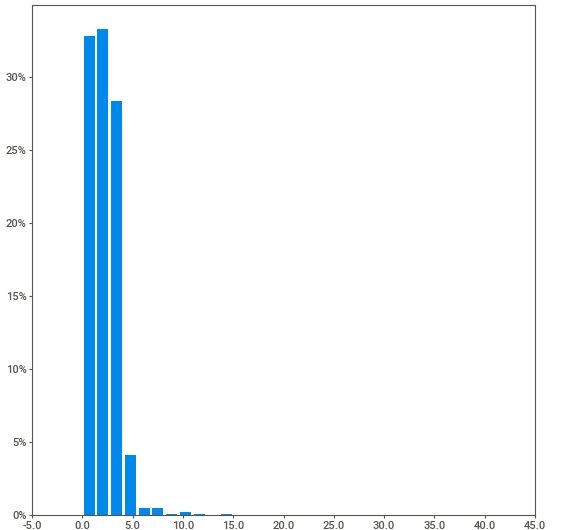
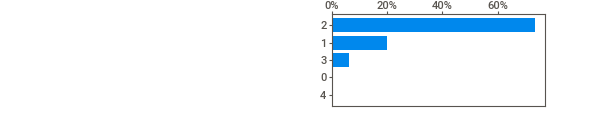
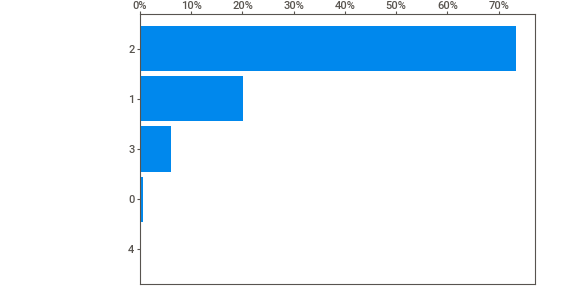
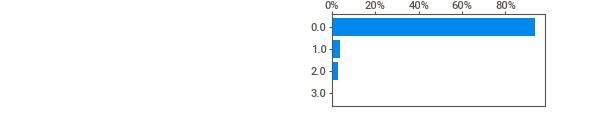
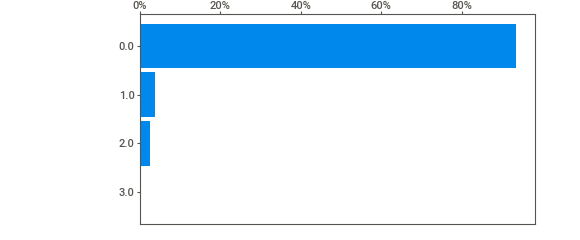
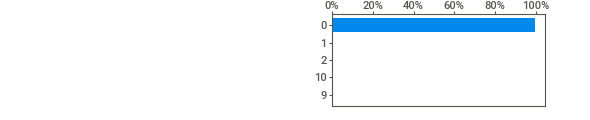
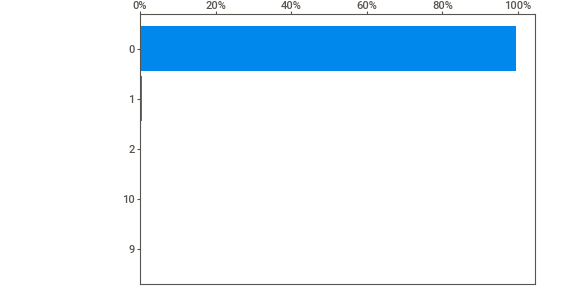
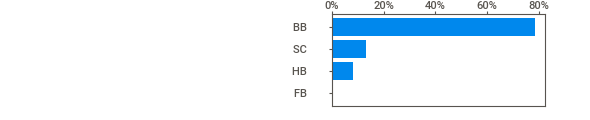
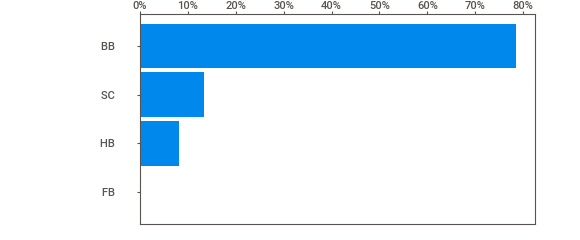
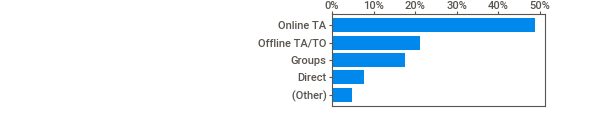
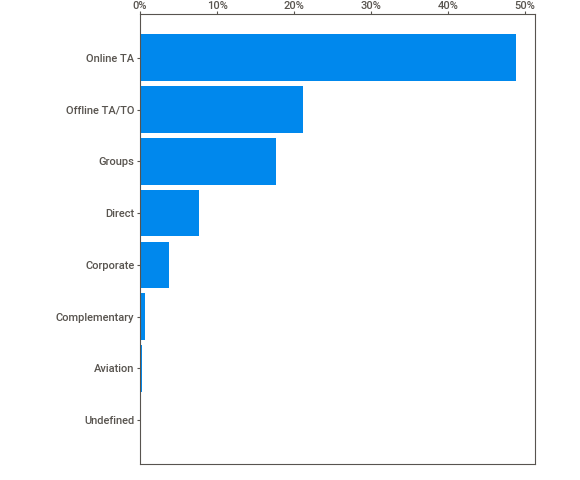
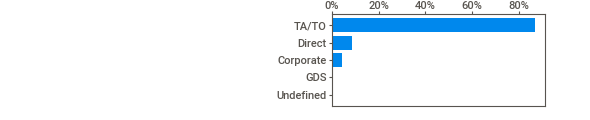
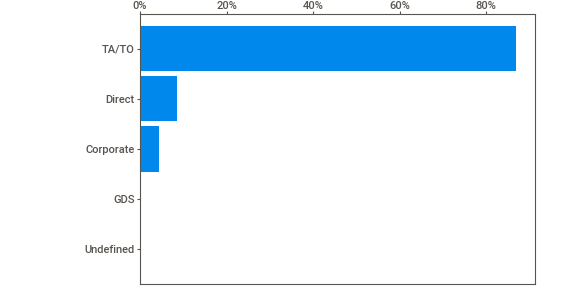
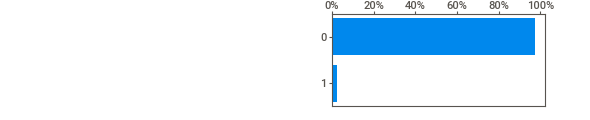
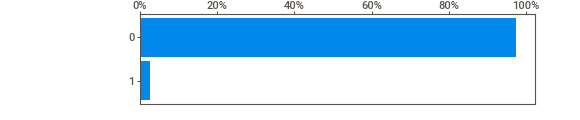
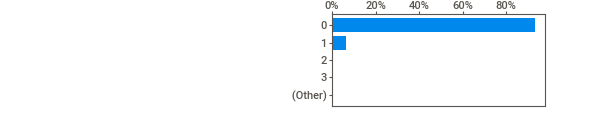
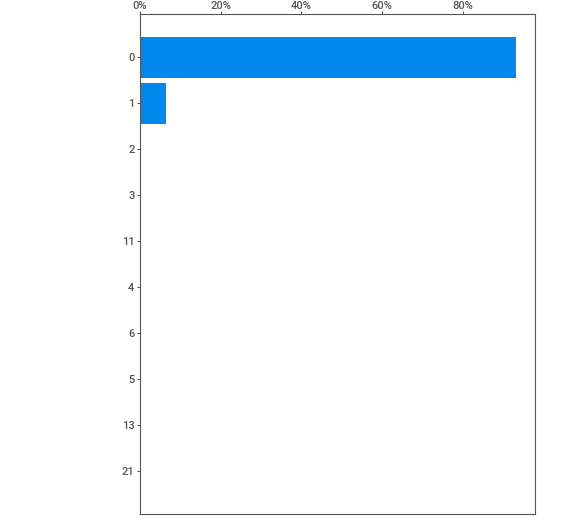
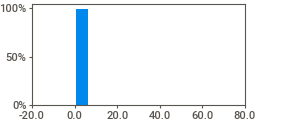
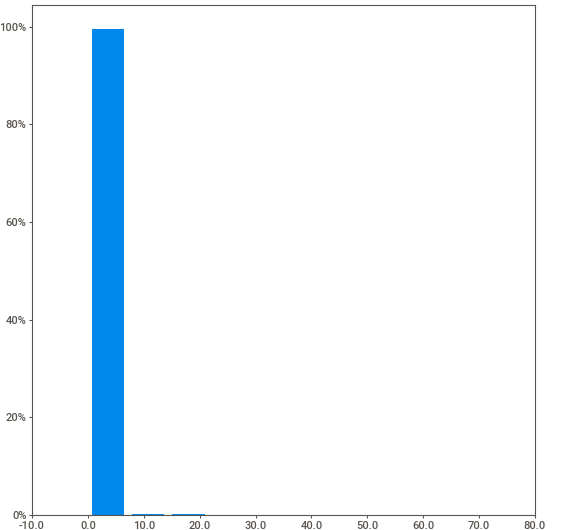
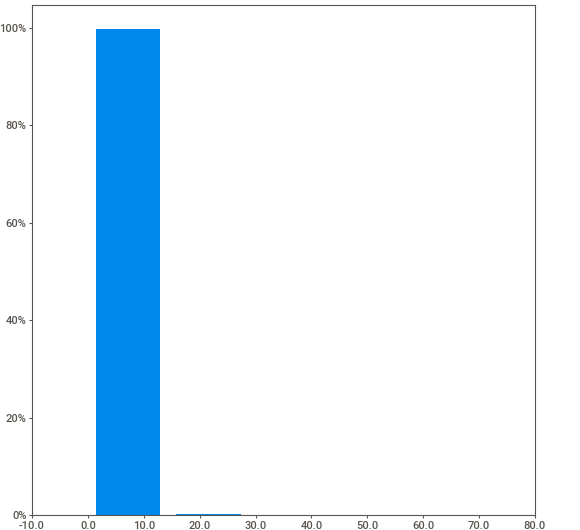
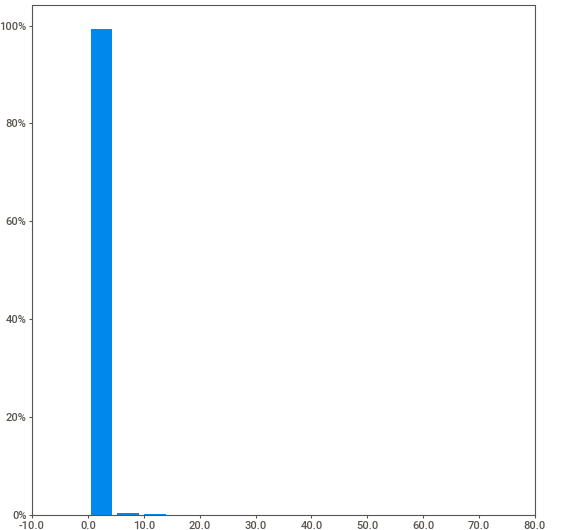
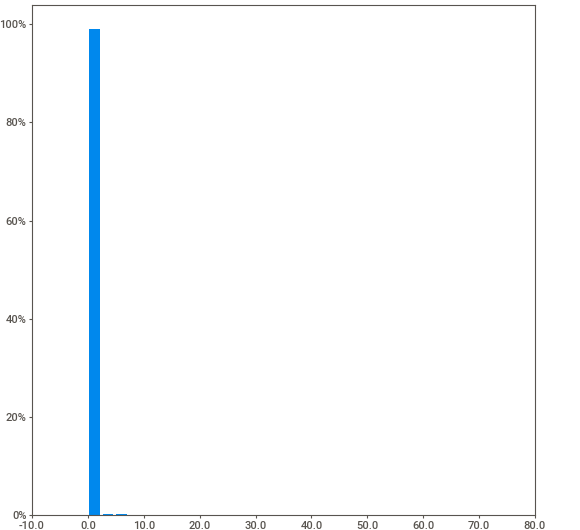
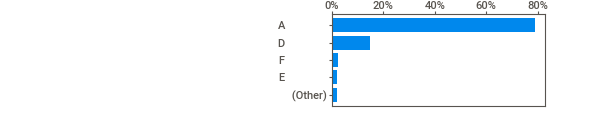
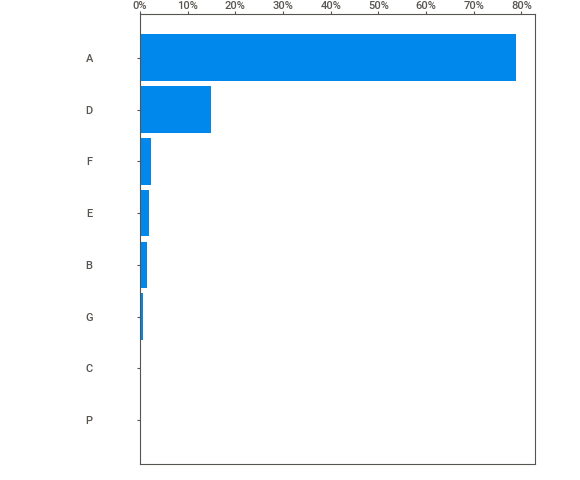
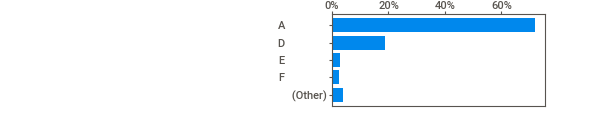
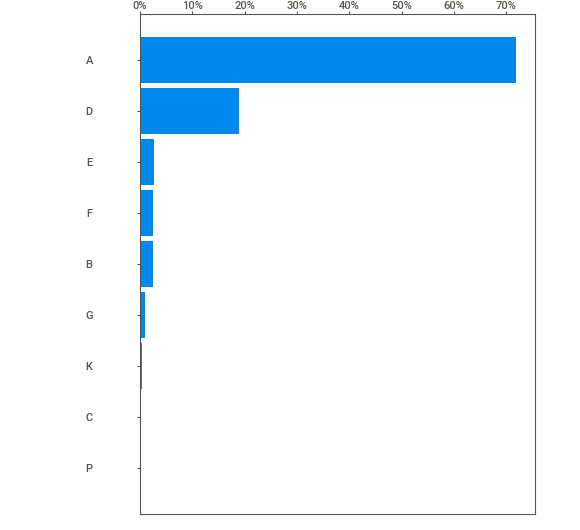
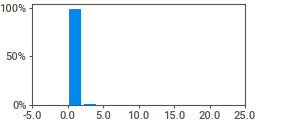
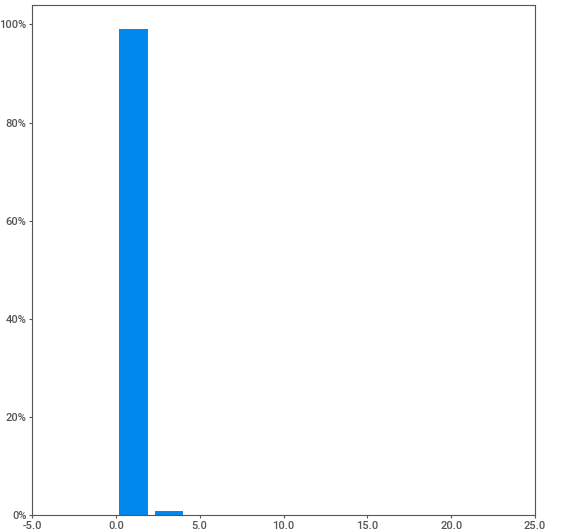
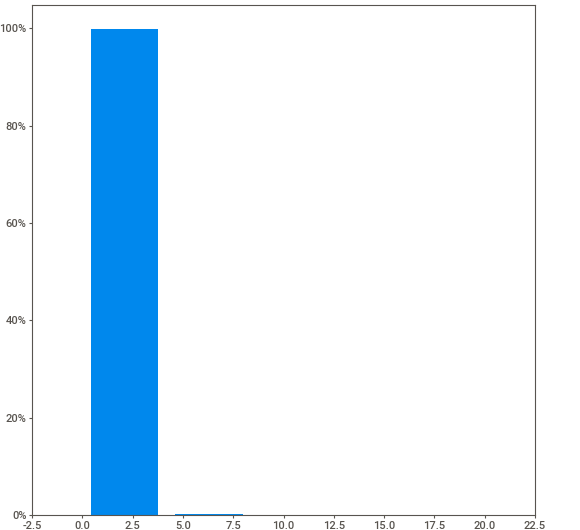
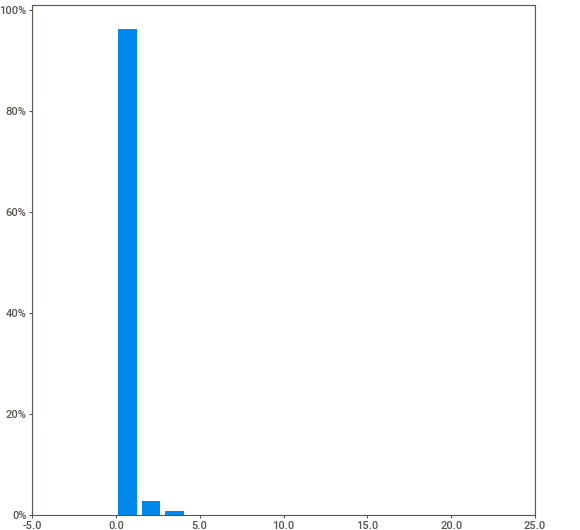
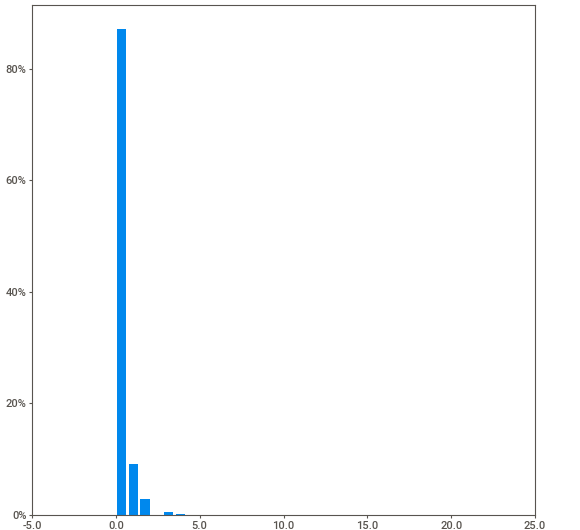
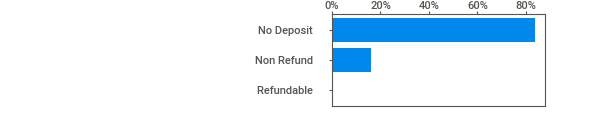
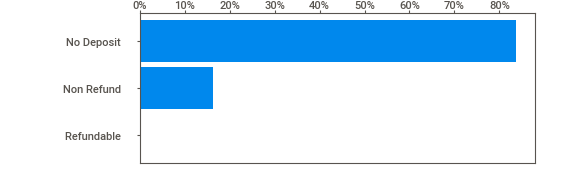
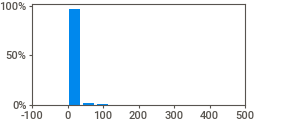
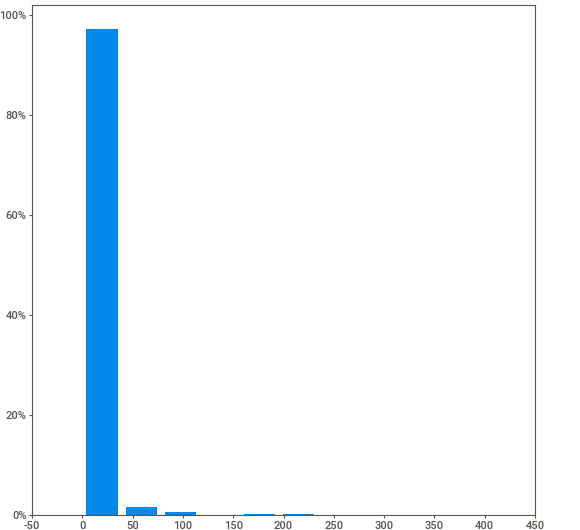
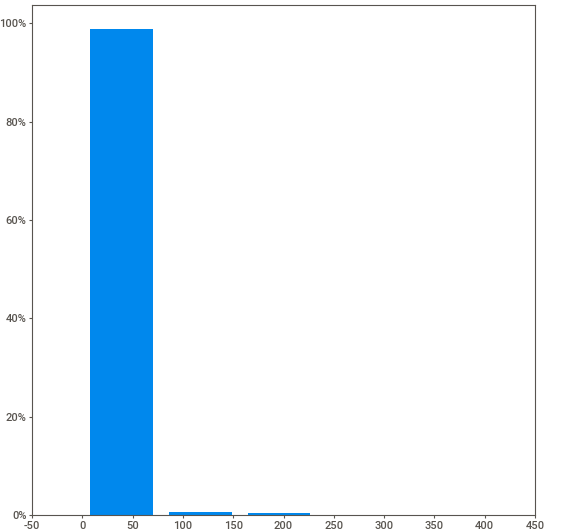
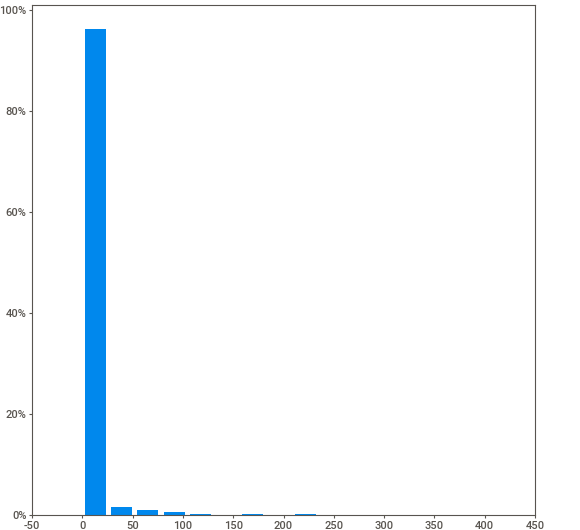
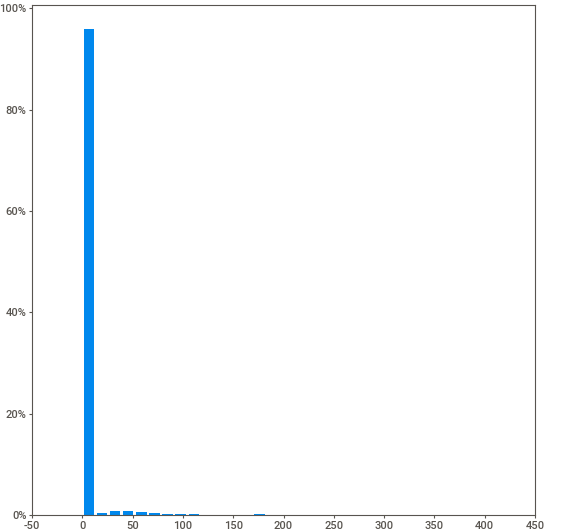
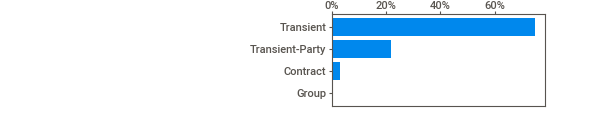
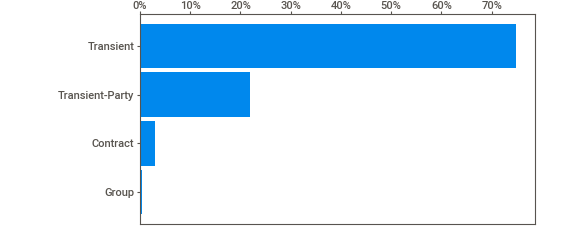
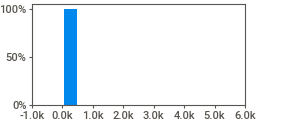
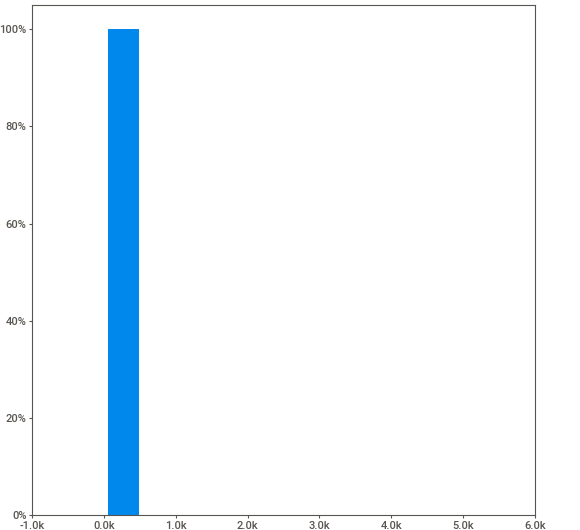
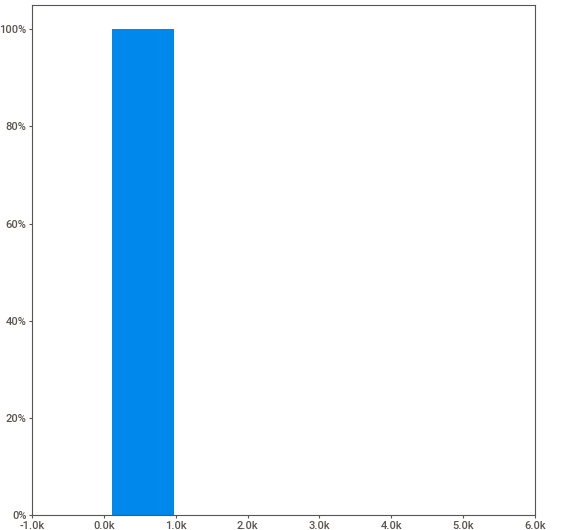
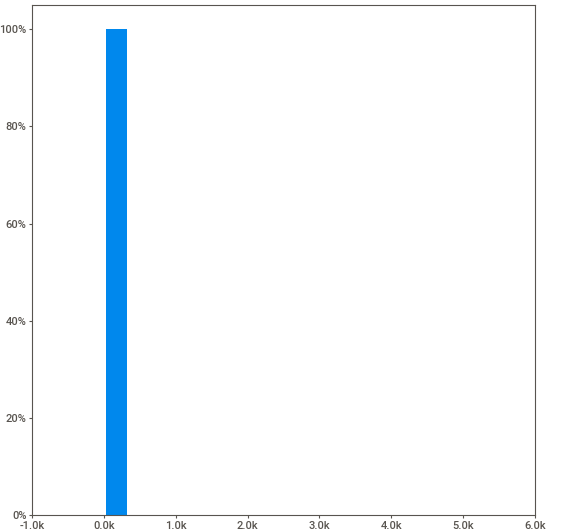
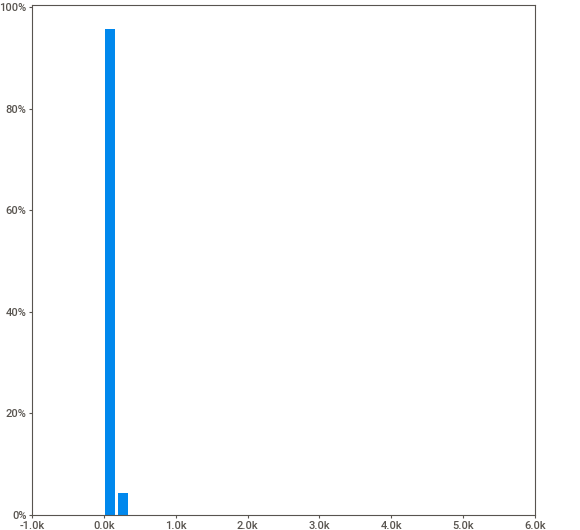
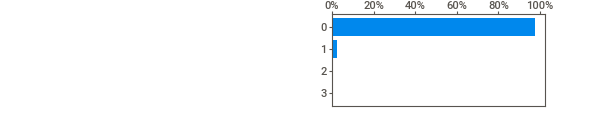
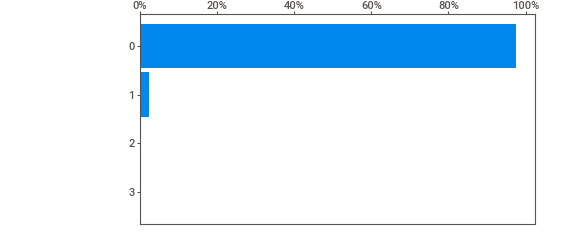
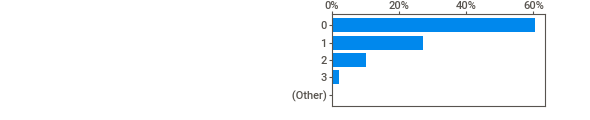
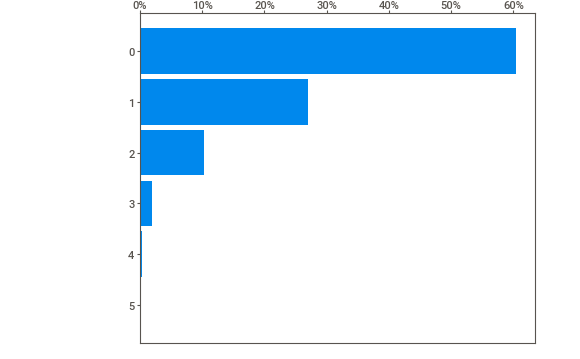
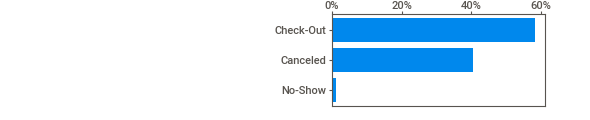
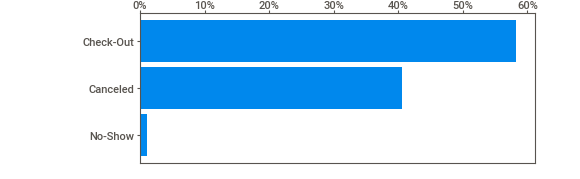
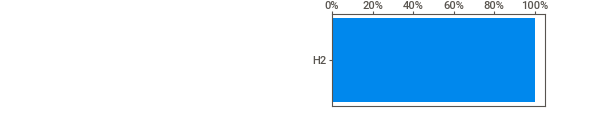
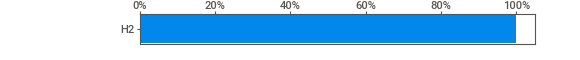

In [4]:
report = sv.analyze(df_h2,pairwise_analysis = 'off')
report.show_notebook()

### **EDA Results**

---

**Feature Review**

1. **IsCanceled**: 
   - **Type**: Binary
   - **Notes**: This feature is too strongly related to the target feature, `ReservationStatus`, and will cause problems for modeling. I will drop this feature after completing my EDA.

2. **LeadTime**:
   - **Type**: Numeric, Continuous
   - **Distribution**: Right-skewed
   - **Action**: Consider applying a Yeo-Johnson transformation to correct skewness, or evaluate whether to drop extreme outliers if they are not representative of typical booking patterns.

3. **Date Features** (e.g., ArrivalDate, DepartureDate):
   - **Type**: DateTime
   - **Action**: Move these features to the feature engineering phase for generating time series details, such as day of the week, month, or seasonality effects.

4. **Adults, Children, Babies**:
   - **Type**: Numeric, Discrete
   - **Distribution**: Right-skewed
   - **Action**: Evaluate the necessity of transforming these features to reduce skewness or consider removing outliers that could distort the analysis.

5. **Meal**:
   - **Type**: Categorical
   - **Action**: Perform encoding during the modeling pipeline preprocessing to convert this feature into a format suitable for machine learning models.

6. **Country**:
   - **Type**: Categorical
   - **Action**: Encode this feature during preprocessing. Given the high cardinality (many unique countries), consider using a method that reduces dimensionality, such as frequency encoding or grouping similar countries.

7. **PreviousCancellations / PreviousBookingsNotCancelled**:
   - **Type**: Numeric, Discrete
   - **Notes**: These features are particularly useful for post-booking forecasts but are less applicable for pre-booking revenue forecasting. Their predictive power might be more relevant to behavioral analysis after a booking is made.

8. **BookedRoomType / AssignedRoomType**:
   - **Type**: Categorical
   - **Notes**: The `AssignedRoomType` is not known until after the stay, which makes it a candidate for feature engineering. You could explore classification models to predict the assigned room type or analyze the matching between booking and assignment.

9. **BookingChanges**:
   - **Type**: Numeric, Discrete
   - **Distribution**: Right-skewed
   - **Action**: Plan to transform this feature during preprocessing to manage skewness.

10. **DepositType**:
    - **Type**: Categorical
    - **Action**: Perform encoding during preprocessing.

11. **Agent, Company**:
    - **Type**: Categorical
    - **Action**: These features require encoding during preprocessing. Given potential high cardinality, consider using frequency encoding or similar techniques.

12. **DaysInWaitingList**:
    - **Type**: Numeric, Discrete
    - **Distribution**: Right-skewed
    - **Action**: This feature should be transformed during preprocessing to reduce skewness.

13. **ADR (Average Daily Rate)**:
    - **Type**: Numeric, Continuous
    - **Notes**: While no longer the target feature, ADR remains an important predictor. It has negative values that should be examined—decide whether to retain, drop, or adjust these values (e.g., bringing all values above zero). ADR is also right-skewed and could benefit from transformation (e.g., log or Yeo-Johnson) during preprocessing.

14. **RequiredParkingSpaces**:
    - **Type**: Numeric, Discrete
    - **Distribution**: Right-skewed
    - **Action**: Apply transformation during preprocessing to manage skewness.

15. **ReservationStatus** (Target Feature):
    - **Type**: Categorical
    - **Notes**: This feature indicates the final status of a reservation (e.g., canceled, checked-in, no-show). It is the target for classification modeling. It's important to avoid data leakage by ensuring that no features derived from this status are used inappropriately.

16. **ReservationStatusDate**:
    - **Type**: DateTime
    - **Action**: Utilize this feature in temporal feature engineering, such as calculating the time between booking and status change, or deriving features related to the timing of the status update.

---

 **Review Summary**

- **Numeric Features**: Several numeric features exhibit right-skewness and contain extreme outliers. These characteristics suggest that transformations, such as Yeo-Johnson, could be beneficial. However, in some cases, it may be appropriate to drop extreme outliers if they do not represent typical data patterns.

- **Categorical Features**: Many categorical features, especially those with high cardinality (e.g., `Country`, `Agent`, `Company`), will need encoding. To avoid the dimensionality explosion that comes with one-hot encoding, techniques like frequency encoding or grouping should be considered.

- **Multicollinearity**: Multicollinearity is a concern, particularly for linear models. It will be essential to evaluate and potentially remove highly correlated features using methods such as Variance Inflation Factor (VIF) analysis.

- **Target Feature (ReservationStatus)**: The target for classification, `ReservationStatus`, requires careful handling to ensure that features derived from it do not introduce data leakage into the model.

---

**Next Steps**

- **Outliers and Skewness**: Apply transformations such as Yeo-Johnson during the preprocessing phase to address skewness in numeric features. Consider dropping extreme outliers if they do not contribute meaningful information.

- **Categorical Encoding**: Implement encoding for categorical features during the modeling pipeline, focusing on methods that manage high cardinality, such as CountFrequencyEncoder.

- **Address Multicollinearity**: For linear models, use VIF analysis or similar methods to detect and mitigate multicollinearity among features.

- **Feature Engineering**: Incorporate time-based features and engineered features derived from `ReservationStatusDate` and other date features to enhance the model's predictive power.

---

## Comparing `IsCanceled` to `ReservationStatus`

In [5]:
df_h1[['IsCanceled', 'ReservationStatus']].value_counts()

IsCanceled  ReservationStatus
0           Check-Out            28938
1           Canceled             10831
            No-Show                291
Name: count, dtype: int64

In [6]:
df_h2[['IsCanceled', 'ReservationStatus']].value_counts()

IsCanceled  ReservationStatus
0           Check-Out            46228
1           Canceled             32186
            No-Show                916
Name: count, dtype: int64

## Dropping `ReservationStatus` and Saving Results

In [7]:
df_h1 = df_h1.drop(columns = 'ReservationStatus')
df_h2 = df_h2.drop(columns = 'ReservationStatus')

# Exploratory Data Analysis: Summary Stats

## Hotel 1

In [8]:
## Numeric Stats
df_h1.describe(include = 'number').T

,count,mean,std,min,25%,50%,75%,max
IsCanceled,"40,060.00",0.28,0.45,0.00,0.00,0.00,1.00,1.00
LeadTime,"40,060.00",92.68,97.29,0.00,10.00,57.00,155.00,737.00
ArrivalDateYear,"40,060.00","2,016.12",0.72,"2,015.00","2,016.00","2,016.00","2,017.00","2,017.00"
ArrivalDateWeekNumber,"40,060.00",27.14,14.01,1.00,16.00,28.00,38.00,53.00
ArrivalDateDayOfMonth,"40,060.00",15.82,8.88,1.00,8.00,16.00,24.00,31.00
StaysInWeekendNights,"40,060.00",1.19,1.15,0.00,0.00,1.00,2.00,19.00
StaysInWeekNights,"40,060.00",3.13,2.46,0.00,1.00,3.00,5.00,50.00
Adults,"40,060.00",1.87,0.70,0.00,2.00,2.00,2.00,55.00
Children,"40,060.00",0.13,0.45,0.00,0.00,0.00,0.00,10.00
Babies,"40,060.00",0.01,0.12,0.00,0.00,0.00,0.00,2.00


---

- Outliers present in nearly half of the features
- Power transformations/removal may be required in preprocessing pipeline to minimize impact on models

---

In [9]:
## Non-Numeric Stats
df_h1.describe(include = 'object').T

,count,unique,top,freq
ArrivalDateMonth,40060,12,August,4894
Meal,40060,5,BB,30005
Country,39596,125,PRT,17630
MarketSegment,40060,6,Online TA,17729
DistributionChannel,40060,4,TA/TO,28925
ReservedRoomType,40060,10,A,23399
AssignedRoomType,40060,11,A,17046
DepositType,40060,3,No Deposit,38199
Agent,40060,186,240,13905
Company,40060,236,NULL,36952


---

- High cardinality in Country, Agent, Company

---

## Hotel 2

In [10]:
## Numeric Stats
df_h2.describe(include = 'number').T

,count,mean,std,min,25%,50%,75%,max
IsCanceled,"79,330.00",0.42,0.49,0.00,0.00,0.00,1.00,1.00
LeadTime,"79,330.00",109.74,110.95,0.00,23.00,74.00,163.00,629.00
ArrivalDateYear,"79,330.00","2,016.17",0.70,"2,015.00","2,016.00","2,016.00","2,017.00","2,017.00"
ArrivalDateWeekNumber,"79,330.00",27.18,13.40,1.00,17.00,27.00,38.00,53.00
ArrivalDateDayOfMonth,"79,330.00",15.79,8.73,1.00,8.00,16.00,23.00,31.00
StaysInWeekendNights,"79,330.00",0.80,0.89,0.00,0.00,1.00,2.00,16.00
StaysInWeekNights,"79,330.00",2.18,1.46,0.00,1.00,2.00,3.00,41.00
Adults,"79,330.00",1.85,0.51,0.00,2.00,2.00,2.00,4.00
Children,"79,326.00",0.09,0.37,0.00,0.00,0.00,0.00,3.00
Babies,"79,330.00",0.00,0.08,0.00,0.00,0.00,0.00,10.00


---

- Outliers present in nearly half of the features
- Power transformations/removal may be required in preprocessing pipeline to minimize impact on models

---

In [11]:
## Non-Numeric Stats
df_h2.describe(include = 'object').T

,count,unique,top,freq
ArrivalDateMonth,79330,12,August,8983
Meal,79330,4,BB,62305
Country,79306,166,PRT,30960
MarketSegment,79330,8,Online TA,38748
DistributionChannel,79330,5,TA/TO,68945
ReservedRoomType,79330,8,A,62595
AssignedRoomType,79330,9,A,57007
DepositType,79330,3,No Deposit,66442
Agent,79330,224,9,31955
Company,79330,208,NULL,75641


---

- High cardinality in Country, Agent, Company

---

# Review Missing Values

In [12]:
nan_sum = df_h1.isna().sum()
nan_sum[nan_sum > 0]

Country    464
dtype: int64

In [13]:
nan_avg = df_h1.isna().mean()
nan_avg[nan_avg > 0]

Country   0.01
dtype: float64

In [14]:
nan_sum = df_h2.isna().sum()
nan_sum[nan_sum > 0]

Children     4
Country     24
dtype: int64

In [15]:
nan_avg = df_h2.isna().mean()
nan_avg[nan_avg > 0]

Children   0.00
Country    0.00
dtype: float64

---

- Two features missing values
- Average number of missing values less than 1%
- No action taken; will address in model pipeline

---

# Inspecting Canceled Reservations

In [16]:
(df_h1[df_h1['IsCanceled'] == 1]).describe(include = 'number').T

,count,mean,std,min,25%,50%,75%,max
IsCanceled,"11,122.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00
LeadTime,"11,122.00",128.68,98.82,0.00,44.00,109.00,198.00,471.00
ArrivalDateYear,"11,122.00","2,016.17",0.73,"2,015.00","2,016.00","2,016.00","2,017.00","2,017.00"
ArrivalDateWeekNumber,"11,122.00",27.63,12.83,1.00,18.00,29.00,37.00,53.00
ArrivalDateDayOfMonth,"11,122.00",15.69,8.97,1.00,8.00,16.00,24.00,31.00
StaysInWeekendNights,"11,122.00",1.34,1.14,0.00,0.00,1.00,2.00,16.00
StaysInWeekNights,"11,122.00",3.44,2.46,0.00,2.00,3.00,5.00,40.00
Adults,"11,122.00",1.96,1.08,0.00,2.00,2.00,2.00,55.00
Children,"11,122.00",0.19,0.54,0.00,0.00,0.00,0.00,10.00
Babies,"11,122.00",0.01,0.10,0.00,0.00,0.00,0.00,2.00


In [17]:
(df_h2[df_h2['IsCanceled'] == 1]).describe(include = 'number').T

,count,mean,std,min,25%,50%,75%,max
IsCanceled,"33,102.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00
LeadTime,"33,102.00",150.28,124.10,0.00,50.00,115.00,226.00,629.00
ArrivalDateYear,"33,102.00","2,016.17",0.71,"2,015.00","2,016.00","2,016.00","2,017.00","2,017.00"
ArrivalDateWeekNumber,"33,102.00",27.20,13.17,1.00,17.00,27.00,38.00,53.00
ArrivalDateDayOfMonth,"33,102.00",15.74,8.73,1.00,8.00,16.00,23.00,31.00
StaysInWeekendNights,"33,102.00",0.79,0.92,0.00,0.00,1.00,2.00,10.00
StaysInWeekNights,"33,102.00",2.27,1.53,0.00,1.00,2.00,3.00,24.00
Adults,"33,102.00",1.88,0.47,0.00,2.00,2.00,2.00,4.00
Children,"33,098.00",0.08,0.35,0.00,0.00,0.00,0.00,3.00
Babies,"33,102.00",0.00,0.04,0.00,0.00,0.00,0.00,1.00


# Feature Selection - Known at Booking/Pre-Arrival

---

While some of the features in my dataset may not be known at the time of booking, **I will retain almost all of the source features for my initial modeling efforts.** This approach allows me to assess the overall predictive power of the model using the full feature set.

If the initial models perform well, I will then refine the feature selection by removing those features that are less likely to be known at the time of booking. This step will help ensure that the model more accurately reflects the reservation process and improves its applicability in real-world scenarios.

---

# **Final Summary and Next Steps**

---

The exploratory data analysis (EDA) process has provided a comprehensive understanding of the dataset, highlighting key characteristics, potential issues, and opportunities for feature engineering.

Several numeric features were found to be right-skewed with notable outliers, while categorical features often exhibited high cardinality. The analysis also revealed a degree of multicollinearity, particularly concerning for linear models, which will need to be addressed during the modeling process.

Additionally, while the target feature for classification, `IsCanceled`, is crucial for predicting outcomes, careful consideration is needed to avoid data leakage from features that may not be known at the time of booking.

---

**Next Steps**

1. **Baseline Modeling**: 
   - Begin by developing baseline models using the full set of features identified during the EDA. This will provide an initial understanding of the model's performance and help identify which features contribute most to the predictions.

2. **Feature Engineering**:
   - After establishing the baseline, proceed with feature engineering to create new, potentially more predictive features. This includes deriving temporal features from date-related data and calculating occupancy statistics for each hotel.

3. **Dataset Expansion**:
   - Expand the dataset as described earlier by creating daily records for each reservation. This will allow for the calculation of daily occupancy rates and other time-sensitive metrics that can be used as additional features in the model.


***Above and Beyond***

- Based on the initial model performance, iteratively refine the feature set by removing features that are less likely to be known at the time of booking. This step will help align the model more closely with the real-world reservation process and improve its generalizability.

---

**Final Notes**

By following these steps, the project will transition from EDA to more advanced modeling, enabling a deeper analysis of reservation patterns and ultimately leading to more accurate predictions of reservation outcomes.

---